# Import packages

In [89]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, time_resolved_gpfa_regression,plot_time_resolved_regression
from neural_data_analysis.neural_analysis_tools.align_trials import align_trial_utils
from decision_making_analysis.compare_GUAT_and_TAFT import find_GUAT_or_TAFT_trials

from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth import core_stops_psth, get_stops_utils, psth_postprocessing, psth_stats, compare_events, dpca_utils
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_fit import stop_glm_fit, cv_stop_glm, glm_fit_utils, variance_explained
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_plotting import plot_spikes, plot_glm_fit, plot_tuning_func
from neural_data_analysis.design_kits.design_around_event import event_binning, stop_design, cluster_design, design_checks
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_hyperparams import compare_glm_configs, glm_hyperparams_class
from neural_data_analysis.topic_based_neural_analysis.ff_visibility import ff_vis_epochs, vis_design
from neural_data_analysis.neural_analysis_tools.glm_tools.glm_decoding_tools import glm_decoding_llr

import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr
import statsmodels.api as sm

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

print("done")


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# retrieve data

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0413"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0321"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0329"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0403"

In [55]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"


raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0316"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"

In [56]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)

if not hasattr(pn, 'spikes_df'):
    pn.retrieve_or_make_monkey_data()
    pn.spikes_df = neural_data_processing.make_spikes_df(pn.raw_data_folder_path, pn.ff_caught_T_sorted,
                                                            sampling_rate=pn.sampling_rate)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0316/binned_spikes_df_0p05.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0316/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0316/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0316/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
There are 5 duplicated point_index in bin_info. Note: one_point_index_per_bin is False


# NEXT: try stop end time instead

# Get captures

In [57]:
# Example wiring (mirrors your original usage)
captures_df, valid_captures_df, filtered_no_capture_stops_df, stops_with_stats = get_stops_utils.prepare_no_capture_and_captures(
    monkey_information=pn.monkey_information,
    closest_stop_to_capture_df=pn.closest_stop_to_capture_df,
    ff_caught_T_new=pn.ff_caught_T_new,
    capture_match_window=0.3,
    distance_col="distance_from_ff_to_stop",
)


# Get misses

##  one

In [58]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]

pn.make_one_stop_w_ff_df()
one_stop_miss_df = pn.one_stop_w_ff_df[['first_stop_point_index', 'first_stop_time', 'latest_visible_ff', 'ff_distance']].copy()
one_stop_miss_df.rename(columns={'first_stop_point_index': 'stop_point_index', 'first_stop_time': 'stop_time'}, inplace=True)
one_stop_miss_df[columns_to_add] = pn.monkey_information.loc[one_stop_miss_df['stop_point_index'], columns_to_add].values

Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0316/ff_dataframe.h5


## more

In [59]:
pn.make_or_retrieve_ff_dataframe()
pn.get_try_a_few_times_info()
pn.get_give_up_after_trying_info()


before calling deal_with_duplicated_stop_point_index, len(GUAT_w_ff_df) 130
after calling deal_with_duplicated_stop_point_index, len(GUAT_w_ff_df) 130


In [60]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]
shared_columns = ["stop_point_index", "stop_time"] + columns_to_add

# --- Build expanded + ordered tables for GUAT / TAFT ---
GUAT_expanded = get_stops_utils._expand_trials(pn.GUAT_trials_df, pn.monkey_information)
TAFT_expanded = get_stops_utils._expand_trials(pn.TAFT_trials_df, pn.monkey_information)

# add event_id to GUAT_trials_df and TAFT_trials_df
GUAT_expanded[columns_to_add] = pn.monkey_information.loc[GUAT_expanded['stop_point_index'], columns_to_add].values
TAFT_expanded[columns_to_add] = pn.monkey_information.loc[TAFT_expanded['stop_point_index'], columns_to_add].values


GUAT = get_stops_utils._add_cluster_ordering(GUAT_expanded)
TAFT = get_stops_utils._add_cluster_ordering(TAFT_expanded)

# --- Per-cluster slices (consistent, vectorized) ---
# First stop in each cluster
GUAT_first = GUAT[GUAT["is_first"]].reset_index(drop=True)
TAFT_first = TAFT[TAFT["is_first"]].reset_index(drop=True)

# Last stop in each cluster
giveup_GUAT_last = GUAT[GUAT["is_last"]].reset_index(drop=True)
capture_TAFT_last = TAFT[TAFT["is_last"]].reset_index(drop=True)

# Middle stops (exclude first and last)
GUAT_middle = GUAT[GUAT["is_middle"]].reset_index(drop=True)
TAFT_middle = TAFT[TAFT["is_middle"]].reset_index(drop=True)

# “First several” = all but the last stop in each cluster
GUAT_nonfinal = GUAT[GUAT["order_in_cluster"] < GUAT["cluster_size"] - 1].reset_index(drop=True)
TAFT_nonfinal = TAFT[TAFT["order_in_cluster"] < TAFT["cluster_size"] - 1].reset_index(drop=True)

# Combine the “first several” from both, keep only columns you care about, then sort by index
both_nonfinal = (
    pd.concat(
        [
            GUAT_nonfinal[shared_columns],
            TAFT_nonfinal[shared_columns],
        ],
        ignore_index=True
    )
    .sort_values("stop_point_index")
    .reset_index(drop=True)
)

persist_both_first = pd.concat([GUAT_first[shared_columns], 
                         TAFT_first[shared_columns]])

both_middle = pd.concat([GUAT_middle[shared_columns], 
                         TAFT_middle[shared_columns]])

# Optional: if you also want “last several” (all but the first), it’s symmetrical:
# giveup_GUAT_last_several = GUAT[GUAT["order_in_cluster"] > 0].reset_index(drop=True)
# capture_TAFT_last_several = TAFT[TAFT["order_in_cluster"] > 0].reset_index(drop=True)

giveup_GUAT_last_plus_single_miss = pd.concat([giveup_GUAT_last[shared_columns], 
                                         one_stop_miss_df[shared_columns]])

all_misses = pd.concat([one_stop_miss_df[shared_columns], 
                                         GUAT_expanded[shared_columns],
                                         TAFT_nonfinal[shared_columns]
                                         ])

all_first_misses = pd.concat(
    [one_stop_miss_df[shared_columns], GUAT_first[shared_columns], TAFT_first[shared_columns]],
    ignore_index=True
)

# captures not in TAFT last (assuming capture_TAFT_last is a subset of captures)
captures_minus_TAFT_last = compare_events.diff_by(valid_captures_df, capture_TAFT_last, key='stop_id')

# non-captures excluding those flagged as 'all_misses'
non_captures_minus_all_misses = compare_events.diff_by(filtered_no_capture_stops_df, all_misses, key='stop_id')


# Get stop info

## new_seg_info

In [61]:
stops_with_stats['stop_time'] = stops_with_stats['stop_id_start_time']
stops_with_stats['prev_time'] = stops_with_stats['stop_id_end_time'].shift(1)
stops_with_stats['next_time'] = stops_with_stats['stop_id_start_time'].shift(-1)
new_seg_info = event_binning.pick_event_window(stops_with_stats,
                                                pre_s=0.2, post_s=1.0, min_pre_bins=1, min_post_bins=20, bin_dt=0.04)

if 'stop_id' not in pn.closest_stop_to_capture_df.columns:
    pn.closest_stop_to_capture_df = get_stops_utils.add_stop_id_to_closest_stop_to_capture_df(
        pn.closest_stop_to_capture_df,
        pn.monkey_information,
    )
    
if 'captured' not in new_seg_info.columns:
    pn.closest_stop_to_capture_df['captured'] = 1
    new_seg_info = new_seg_info.merge(pn.closest_stop_to_capture_df[['stop_id', 'captured']].drop_duplicates(), on='stop_id', how='left')
    new_seg_info['captured'] = new_seg_info['captured'].fillna(0)
    
new_seg_info['event_id'] = new_seg_info['stop_id']
new_seg_info['event_time'] = new_seg_info['stop_time']

In [62]:
events_with_stats = stops_with_stats[['stop_id','stop_cluster_id','stop_id_start_time','stop_id_end_time']].copy()
events_with_stats.rename(columns={'stop_id':'event_id', 'stop_cluster_id':'event_cluster_id', 'stop_id_start_time':'event_id_start_time', 'stop_id_end_time':'event_id_end_time'}, inplace=True)


## add misses and retries

miss: all_misses
first miss: all_first_misses 
persist: GUAT_nonfinal + TAFT
first retry: persist_both_first
second or more retry: persist_middle
capture after persist: capture_TAFT_last
give up after first try: one_stop_miss_df
give up after persist: giveup_GUAT_last

actually it's easier to do it based on categories (it's only to break the above done into final categories, which is fine for now)

In [63]:
extra_info = [('GUAT_first', GUAT_first), ('TAFT_first', TAFT_first),
                ('GUAT_middle', GUAT_middle), ('TAFT_middle', TAFT_middle),
                ('GUAT_last', giveup_GUAT_last), ('TAFT_last', capture_TAFT_last),
                ('one_stop_miss_df', one_stop_miss_df)]

for col, df in extra_info:
    new_seg_info[col] = 0
    category_stop_ids = df['stop_id'].unique()
    new_seg_info.loc[new_seg_info['stop_id'].isin(category_stop_ids), col] = 1
    
extra_columns = ['GUAT_first', 'TAFT_first', 'GUAT_middle', 'TAFT_middle', 'GUAT_last', 'TAFT_last', 'one_stop_miss_df']
    

## what if only keep stop clusters w captured

In [64]:
# cluster_id_w_captures = new_seg_info.loc[new_seg_info['captured'] == 1, 'stop_cluster_id'].unique()
# new_seg_info = new_seg_info[new_seg_info['stop_cluster_id'].isin(cluster_id_w_captures)].copy()

In [65]:
# new_seg_info = new_seg_info[new_seg_info['captured'] == 1].copy()
# new_seg_info

## exp

In [66]:
# 1) Build bins from your event windows (gaps allowed)
bins_2d, meta = event_binning.event_windows_to_bins2d(new_seg_info, bin_dt=0.04, only_ok=False)


In [67]:
meta

,event_id,k_within_seg,is_pre,t_left,t_right,t_center,rel_left,rel_right,rel_center,exposure_s,event_time,bin
0,0,0,True,29.53671,29.57671,29.55671,-0.16000,-0.12000,-0.14000,0.04000,29.69671,0
1,0,1,True,29.57671,29.61671,29.59671,-0.12000,-0.08000,-0.10000,0.04000,29.69671,1
2,0,2,True,29.61671,29.65671,29.63671,-0.08000,-0.04000,-0.06000,0.04000,29.69671,2
3,0,3,True,29.65671,29.69671,29.67671,-0.04000,0.00000,-0.02000,0.04000,29.69671,3
4,0,4,False,29.69671,29.73671,29.71671,0.00000,0.04000,0.02000,0.04000,29.69671,4
...,...,...,...,...,...,...,...,...,...,...,...,...
48904,2475,24,False,3557.54911,3557.58911,3557.56911,0.80000,0.84000,0.82000,0.04000,3556.74911,48904
48905,2475,25,False,3557.58911,3557.62911,3557.60911,0.84000,0.88000,0.86000,0.04000,3556.74911,48905
48906,2475,26,False,3557.62911,3557.66911,3557.64911,0.88000,0.92000,0.90000,0.04000,3556.74911,48906
48907,2475,27,False,3557.66911,3557.70911,3557.68911,0.92000,0.96000,0.94000,0.04000,3556.74911,48907


# Prepare for GLM

## binned_feats

In [68]:
reload(event_binning)
reload(stop_design)
reload(cluster_design)
reload(design_checks)
reload(stop_glm_fit)
reload(glm_fit_utils)
reload(cv_stop_glm)
reload(plot_tuning_func)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_plotting.plot_tuning_func' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_glm/glm_plotting/plot_tuning_func.py'>

In [69]:
# 1) Build bins from your event windows (gaps allowed)
bins_2d, meta = event_binning.event_windows_to_bins2d(new_seg_info, bin_dt=0.04, only_ok=False)

# 2) Get overlap assignments once
sample_idx, bin_idx_array, dt_array, n_bins = event_binning.build_bin_assignments(
    pn.monkey_information['time'].to_numpy(),
    bins_2d,
)

# 3) Subselect raw samples once
monkey_information_sub = pn.monkey_information.iloc[sample_idx].copy()

# 3a) One pass to get exposure and used_bins
_dummy, exposure, used_bins = event_binning.bin_timeseries_weighted(
    monkey_information_sub['time'].to_numpy(),  # any column of same length works
    dt_array, bin_idx_array, how='mean'
)

# 3b) Aggregate features with the SAME assignments
def agg_feat(col):
    vals = monkey_information_sub[col].to_numpy()
    out, _exp, _ub = event_binning.bin_timeseries_weighted(vals, dt_array, bin_idx_array, how='mean')
    # Defensive checks: exposure/used_bins should match
    assert np.shares_memory(_exp, exposure) or np.allclose(_exp, exposure)
    assert np.array_equal(_ub, used_bins)
    return out

binned_feats = pd.DataFrame({
    'accel':     agg_feat('accel'),
    'speed':     agg_feat('speed'),
    'ang_speed': agg_feat('ang_speed'),
})

# Clean NaNs (optional: choose your policy)
binned_feats = binned_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# 3c) Keep bins with exposure > 0
mask_used = exposure > 0
pos = used_bins[mask_used]
binned_feats = binned_feats.iloc[mask_used].reset_index(drop=True)

meta_by_bin = meta.set_index('bin').sort_index()
meta_used   = meta_by_bin.loc[pos].reset_index()   # rows now match binned_feats 


# 4) Bin spikes per cluster across ALL bins, then slice by pos
spike_counts, cluster_ids = event_binning.bin_spikes_by_cluster(
    pn.spikes_df, bins_2d, time_col='time', cluster_col='cluster'
)

# Sanity checks
assert pos.size == binned_feats.shape[0]
assert spike_counts.shape[0] >= (pos.max() + 1)

binned_spikes = pd.DataFrame(
    spike_counts[pos, :],        # slice rows to align with pos
    columns=cluster_ids,         # cluster IDs as column labels
).reset_index(drop=True)

# Build the stop-aware design block (same helper we wrote earlier)
X_event_df = stop_design.build_event_design_from_meta(
    meta=meta,
    pos=pos,
    new_seg_info=new_seg_info,
    speed_used=binned_feats['speed'].values,
    include_columns=(
        'basis', 'prepost', 'prepost*speed',
        'captured', 'basis*captured', #'prepost*captured',
        #'time_since_prev_event_pre', 'time_to_next_event_post',
        'time_since_prev_event', 'time_to_next_event',
    )
)

cluster_df = cluster_design.build_cluster_features_workflow(
    meta_used[['event_id', 'rel_center']], events_with_stats,
    rel_time_col='rel_center',
    winsor_p=0.5,
    use_midbin_progress=True,
    zscore_progress=False,   # set True if you want progress in SD units
    zscore_rel_time=True
)
cluster_feats = [
        'is_clustered',
        'event_is_first_in_cluster', 
        #'event_is_last_in_cluster',
        'prev_gap_s_z',
        'next_gap_s_z',
        'cluster_duration_s_z',
        'cluster_progress_c', 'cluster_progress_c2',
        #'log_event_cluster_size_z',      # optional
        'cluster_rel_time_s_z',          # optional (bin-level)
    ]


cols_to_add_from_event_design = [c for c in X_event_df.columns if c not in binned_feats.columns]
binned_feats.loc[:, cols_to_add_from_event_design] = X_event_df[cols_to_add_from_event_design].to_numpy()  # equivalent to .values

cols_to_add_from_cluster_design = [c for c in cluster_feats if c not in binned_feats.columns]
binned_feats.loc[:, cols_to_add_from_cluster_design] = cluster_df[cols_to_add_from_cluster_design].to_numpy()  # equivalent to .values

offset_log = np.log(np.clip(exposure[mask_used], 1e-12, None)) 





# --- usage ---
binned_feats_sc, scaled_cols = event_binning.selective_zscore(binned_feats)
binned_feats_sc = sm.add_constant(binned_feats_sc, has_constant='add')
print('Scaled columns:', scaled_cols)

df_X = binned_feats_sc.copy()
df_Y = binned_spikes.copy()


Scaled columns: ['accel', 'speed', 'ang_speed', 'rcos_-0.24s', 'rcos_-0.16s', 'rcos_-0.08s', 'rcos_+0.00s', 'rcos_+0.08s', 'rcos_+0.16s', 'rcos_+0.24s', 'prepost*speed', 'rcos_-0.24s*captured', 'rcos_-0.16s*captured', 'rcos_-0.08s*captured', 'rcos_+0.00s*captured', 'rcos_+0.08s*captured', 'rcos_+0.16s*captured', 'rcos_+0.24s*captured', 'time_since_prev_event', 'time_to_next_event']


In [70]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   event_id                   48909 non-null  int64  
 1   rel_center                 48909 non-null  float64
 2   event_cluster_id           48909 non-null  Int64  
 3   event_cluster_size         48909 non-null  float64
 4   is_clustered               48909 non-null  int64  
 5   event_cluster_size         48909 non-null  float64
 6   event_idx_in_cluster       48909 non-null  float64
 7   event_is_first_in_cluster  48909 non-null  int64  
 8   event_is_last_in_cluster   48909 non-null  int64  
 9   cluster_progress           48909 non-null  float64
 10  cluster_progress_c         48909 non-null  float64
 11  cluster_progress_c2        48909 non-null  float64
 12  has_prev                   48909 non-null  int64  
 13  has_next                   48909 non-null  int

In [71]:


# add more columns
binned_feats['time_rel_to_event_start'] = meta_used['rel_center']


# add ff visible/in-memory info
max_in_memory_time_since_seen = 2
ff_df_sub = pn.ff_dataframe[pn.ff_dataframe['time_since_last_vis']
                                        < max_in_memory_time_since_seen].copy()
ff_df_sub['in_memory'] = 1

for state in ['visible', 'in_memory']:
    k_ff_visible = vis_design.count_visible_from_time_df_fast(
        ff_df_sub,
        bins_2d,
        vis_col=state
    )

    any_ff_visible = (k_ff_visible > 0).astype('int8')

    binned_feats[f'any_ff_{state}'] = any_ff_visible[used_bins]
    binned_feats[f'k_ff_{state}'] = k_ff_visible[used_bins]


# --- usage ---
binned_feats_sc, scaled_cols = event_binning.selective_zscore(binned_feats)
binned_feats_sc = sm.add_constant(binned_feats_sc, has_constant='add')
print('Scaled columns:', scaled_cols)

df_X = binned_feats_sc.copy()
df_Y = binned_spikes.copy()

Scaled columns: ['accel', 'speed', 'ang_speed', 'rcos_-0.24s', 'rcos_-0.16s', 'rcos_-0.08s', 'rcos_+0.00s', 'rcos_+0.08s', 'rcos_+0.16s', 'rcos_+0.24s', 'prepost*speed', 'rcos_-0.24s*captured', 'rcos_-0.16s*captured', 'rcos_-0.08s*captured', 'rcos_+0.00s*captured', 'rcos_+0.08s*captured', 'rcos_+0.16s*captured', 'rcos_+0.24s*captured', 'time_since_prev_event', 'time_to_next_event', 'time_rel_to_event_start', 'k_ff_visible', 'k_ff_in_memory']


In [72]:
event_tbl = stop_design._build_per_event_table(new_seg_info, extras=extra_columns)
meta_used = stop_design._join_event_tbl_avoid_collisions(meta_used, event_tbl)
for col in extra_columns:
    binned_feats[col] = meta_used[col]
    
binned_feats_sc, scaled_cols = event_binning.selective_zscore(binned_feats)
binned_feats_sc = sm.add_constant(binned_feats_sc, has_constant='add')
print('Scaled columns:', scaled_cols)

df_X = binned_feats_sc.copy()
df_Y = binned_spikes.copy()

Scaled columns: ['accel', 'speed', 'ang_speed', 'rcos_-0.24s', 'rcos_-0.16s', 'rcos_-0.08s', 'rcos_+0.00s', 'rcos_+0.08s', 'rcos_+0.16s', 'rcos_+0.24s', 'prepost*speed', 'rcos_-0.24s*captured', 'rcos_-0.16s*captured', 'rcos_-0.08s*captured', 'rcos_+0.00s*captured', 'rcos_+0.08s*captured', 'rcos_+0.16s*captured', 'rcos_+0.24s*captured', 'time_since_prev_event', 'time_to_next_event', 'time_rel_to_event_start', 'k_ff_visible', 'k_ff_in_memory']


In [73]:
binned_feats.describe().T

,count,mean,std,min,25%,50%,75%,max
accel,48909.00000,-79.13734,599.22699,-3461.47950,-166.44170,0.00000,164.05317,3239.52063
speed,48909.00000,62.20428,71.70614,0.00000,0.00000,23.38625,136.35300,200.00000
ang_speed,48909.00000,0.05252,0.57517,-13.70608,-0.00000,0.00019,0.12198,52.52866
prepost,48909.00000,0.77665,0.41650,0.00000,1.00000,1.00000,1.00000,1.00000
rcos_-0.24s,48909.00000,0.03028,0.13881,0.00000,0.00000,0.00000,0.00000,0.79389
rcos_-0.16s,48909.00000,0.12426,0.30276,0.00000,0.00000,0.00000,0.00000,0.97553
rcos_-0.08s,48909.00000,0.20191,0.36139,0.00000,0.00000,0.00000,0.00000,0.97553
rcos_+0.00s,48909.00000,0.21346,0.36299,0.00000,0.00000,0.00000,0.50000,0.97553
rcos_+0.08s,48909.00000,0.21109,0.36270,0.00000,0.00000,0.00000,0.50000,0.97553
rcos_+0.16s,48909.00000,0.19615,0.36057,0.00000,0.00000,0.00000,0.00000,0.97553


In [74]:
binned_feats_sc.describe()

,const,accel,speed,ang_speed,prepost,rcos_-0.24s,rcos_-0.16s,rcos_-0.08s,rcos_+0.00s,rcos_+0.08s,rcos_+0.16s,rcos_+0.24s,prepost*speed,captured,rcos_-0.24s*captured,rcos_-0.16s*captured,rcos_-0.08s*captured,rcos_+0.00s*captured,rcos_+0.08s*captured,rcos_+0.16s*captured,rcos_+0.24s*captured,time_since_prev_event,time_to_next_event,is_clustered,event_is_first_in_cluster,prev_gap_s_z,next_gap_s_z,cluster_duration_s_z,cluster_progress_c,cluster_progress_c2,cluster_rel_time_s_z,time_rel_to_event_start,any_ff_visible,k_ff_visible,any_ff_in_memory,k_ff_in_memory,GUAT_first,TAFT_first,GUAT_middle,TAFT_middle,GUAT_last,TAFT_last,one_stop_miss_df
count,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000,48909.00000
mean,1.00000,0.00000,-0.00000,0.00000,0.77665,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.56652,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.53000,0.63902,0.00078,0.00106,-0.01612,0.03907,0.03642,-0.00000,-0.00000,0.55225,0.00000,0.96678,-0.00000,0.03466,0.09319,0.00955,0.01574,0.06277,0.16621,0.05778
std,0.00000,1.00001,1.00001,1.00001,0.41650,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,0.49556,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,0.49910,0.48029,0.60094,0.46672,0.70219,0.18680,0.04081,0.72802,1.00001,0.49727,1.00001,0.17923,1.00001,0.18291,0.29071,0.09725,0.12448,0.24255,0.37227,0.23333
min,1.00000,-5.64457,-0.86750,-23.92104,0.00000,-0.21817,-0.41041,-0.55871,-0.58807,-0.58201,-0.54401,-0.54256,-0.58560,0.00000,-0.14886,-0.27544,-0.36547,-0.38210,-0.37850,-0.35620,-0.36220,-1.84449,-1.61139,0.00000,0.00000,-0.91287,-0.91287,-2.05933,-0.41667,0.00000,-1.43397,-1.49764,0.00000,-0.87082,0.00000,-1.86157,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,-0.14570,-0.86750,-0.09132,1.00000,-0.21817,-0.41041,-0.55871,-0.58807,-0.58201,-0.54401,-0.54256,-0.58560,0.00000,-0.14886,-0.27544,-0.36547,-0.38210,-0.37850,-0.35620,-0.36220,-0.70940,-0.71212,0.00000,0.00000,0.00000,0.00000,-0.58782,0.00000,0.00000,-0.29051,-0.82263,0.00000,-0.87082,1.00000,-0.58922,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,1.00000,0.13207,-0.54135,-0.09098,1.00000,-0.21817,-0.41041,-0.55871,-0.58807,-0.58201,-0.54401,-0.54256,-0.58560,1.00000,-0.14886,-0.27544,-0.36547,-0.38210,-0.37850,-0.35620,-0.36220,-0.21944,-0.24729,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.14762,1.00000,0.11221,1.00000,0.04695,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,1.00000,0.40584,1.03407,0.12076,1.00000,-0.21817,-0.41041,-0.55871,0.78940,0.79655,-0.54401,-0.54256,0.15960,1.00000,-0.14886,-0.27544,-0.36547,-0.38210,-0.37850,-0.35620,-0.36220,0.43643,0.42146,1.00000,1.00000,0.00000,0.00000,0.00000,0.25000,0.06250,0.00000,0.66239,1.00000,0.11221,1.00000,0.68312,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,1.00000,5.53829,1.92169,91.23626,1.00000,5.50126,2.81170,2.14072,2.09945,2.10763,2.16155,2.18060,2.50525,1.00000,8.03107,4.14351,3.20148,3.14210,3.15442,3.23283,3.21867,8.71990,8.93330,1.00000,1.00000,1.09545,1.09545,3.82674,0.41667,0.17361,2.71106,2.41741,1.00000,6.01042,1.00000,3.54591,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [75]:
binned_feats_sc[['cluster_progress_c', 'cluster_progress_c2']].describe()

,cluster_progress_c,cluster_progress_c2
count,48909.00000,48909.00000
mean,0.03907,0.03642
std,0.18680,0.04081
min,-0.41667,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,0.25000,0.06250
max,0.41667,0.17361


### drop columns that involve 'captured'

In [76]:
# cols_to_drop = [c for c in binned_feats_sc.columns if 'captured' in c]
# binned_feats_sc = binned_feats_sc.drop(columns=cols_to_drop)
# binned_feats_sc.describe()
# ## check df

In [77]:
binned_feats_sc.shape

(48909, 43)

In [78]:
meta_used.groupby('event_id').size()

event_id
0       11
1        7
2        8
3       16
4       22
        ..
2471    12
2472    16
2473    19
2474    27
2475    29
Length: 2476, dtype: int64

## check df

In [79]:
meta_used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bin               48909 non-null  int64  
 1   event_id          48909 non-null  int64  
 2   k_within_seg      48909 non-null  int64  
 3   is_pre            48909 non-null  bool   
 4   t_left            48909 non-null  float64
 5   t_right           48909 non-null  float64
 6   t_center          48909 non-null  float64
 7   rel_left          48909 non-null  float64
 8   rel_right         48909 non-null  float64
 9   rel_center        48909 non-null  float64
 10  exposure_s        48909 non-null  float64
 11  event_time        48909 non-null  float64
 12  GUAT_first        48909 non-null  int64  
 13  TAFT_first        48909 non-null  int64  
 14  GUAT_middle       48909 non-null  int64  
 15  TAFT_middle       48909 non-null  int64  
 16  GUAT_last         48909 non-null  int64 

In [80]:
used_bins.shape

(48909,)

In [81]:
np.unique(used_bins).shape

(48909,)

In [82]:
binned_feats_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   const                      48909 non-null  float64
 1   accel                      48909 non-null  float64
 2   speed                      48909 non-null  float64
 3   ang_speed                  48909 non-null  float64
 4   prepost                    48909 non-null  float64
 5   rcos_-0.24s                48909 non-null  float64
 6   rcos_-0.16s                48909 non-null  float64
 7   rcos_-0.08s                48909 non-null  float64
 8   rcos_+0.00s                48909 non-null  float64
 9   rcos_+0.08s                48909 non-null  float64
 10  rcos_+0.16s                48909 non-null  float64
 11  rcos_+0.24s                48909 non-null  float64
 12  prepost*speed              48909 non-null  float64
 13  captured                   48909 non-null  flo

# patching up for now

In [83]:
binned_feats_sc.fillna(0, inplace=True)

In [84]:
binned_feats_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   const                      48909 non-null  float64
 1   accel                      48909 non-null  float64
 2   speed                      48909 non-null  float64
 3   ang_speed                  48909 non-null  float64
 4   prepost                    48909 non-null  float64
 5   rcos_-0.24s                48909 non-null  float64
 6   rcos_-0.16s                48909 non-null  float64
 7   rcos_-0.08s                48909 non-null  float64
 8   rcos_+0.00s                48909 non-null  float64
 9   rcos_+0.08s                48909 non-null  float64
 10  rcos_+0.16s                48909 non-null  float64
 11  rcos_+0.24s                48909 non-null  float64
 12  prepost*speed              48909 non-null  float64
 13  captured                   48909 non-null  flo

In [85]:
X_pruned = design_checks.check_design(binned_feats_sc)

NaN/inf present? False
Near-constant: ['const']
Duplicate column groups: []


High-corr pairs (|r| >= 0.98): []
Condition number: 174.05924837896598
rank=43 of 43 columns; deficient? False
                     feature       VIF
0                      const 319.58050
1  event_is_first_in_cluster  53.62053
2               is_clustered  38.47780
3                      speed  28.41825
4              prepost*speed  27.90118
5         cluster_progress_c  23.95287
6                rcos_-0.08s  20.02353
7                rcos_-0.16s  17.61787
8       rcos_-0.08s*captured  16.36488
9       rcos_+0.00s*captured  15.25954


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Suggested drops (order matters): ['event_is_first_in_cluster']


# decoding

In [86]:
decoding_col = 'GUAT_first'

In [87]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

eps = 1e-9


In [88]:
for decoding_col in extra_columns:
    y_visible = df_X[decoding_col].to_numpy()
    groups = meta_used['event_id'].to_numpy()


    # 1) Build params from the report and align to your spike matrix:
    params_df = glm_decoding_llr.params_df_from_coefs_df(report['coefs_df'])     # long → wide
    params_df = glm_decoding_llr.align_params_to_Y(params_df, df_Y)              # row order = df_Y columns

    # 2) Decode on all rows (no CV)
    #    vis_col must match the column name you used for visibility in df_X/params_df.
    llr, p_vis = glm_decoding_llr.decode_from_fitted_glm(
        df_X, 
        df_Y,
        offset_log,
        params_df=params_df,
        vis_col=decoding_col                   # <-- change if your term is named 'visible', etc.
    )

    print('-'*100)
    print(f'{decoding_col}: mean =', df_X[decoding_col].mean())



    # If you have ground-truth per-bin labels:
    auc = roc_auc_score(y_visible, llr)               # using raw LLR is fine
    aupr = average_precision_score(y_visible, p_vis)  # PR-AUC often more informative with class imbalance
    print(f"AUC={auc:.3f}, PR-AUC={aupr:.3f}")

    # Pick an operating point (threshold)
    fpr, tpr, thr = roc_curve(y_visible, llr)
    # Example choices:
    # - Youden J (maximizes tpr - fpr)
    j_idx = np.argmax(tpr - fpr)
    thr_llr = thr[j_idx]

    # Hard labels
    y_hat = (llr >= thr_llr).astype(int)


NameError: name 'glm_decoding_llr' is not defined

## CV

In [ ]:

for decoding_col in extra_columns:
    y_visible = df_X[decoding_col].to_numpy()
    groups = meta_used['event_id'].to_numpy()

    res = glm_decoding_llr.cv_decode_with_glm_report(
        df_X=df_X,                 # design (must include 'any_ff_visible')
        df_Y=df_Y,                 # spikes (T x N), columns are unit IDs
        y=y_visible,               # (T,) 0/1
        groups=groups,             # (T,) session/episode IDs for GroupKFold
        offset_log=offset_log,     # scalar or (T,)
        fit_fn=stop_glm_fit.glm_mini_report,
        fit_kwargs=dict(cov_type='HC1', fast_mle=True, do_inference=False, make_plots=False, show_plots=False),
        bins_2d=bins_2d[used_bins],           # to enable guard-band evaluation
        vis_col=decoding_col,
        n_splits=5,
        standardize=False,         # set True if you want z-scoring of features on train only
        guard=0.05                 # None to disable; else ignores test bins near edges
    )

    print('-'*100)
    print(f'{decoding_col}:')
    print(f"GroupKFold AUC: {res['auc_mean']:.3f} ± {res['auc_std']:.3f} | "
        f"PR-AUC: {res['pr_mean']:.3f} ± {res['pr_std']:.3f} | folds={res['n_splits']}")
    for m in res['fold_metrics']:
        print(f"fold {m['fold']}: AUC={m['auc']:.3f}, PR-AUC={m['pr_auc']:.3f}, n_test={m['n_test']}, kept={m['n_kept']}")


[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 4
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 1
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 2
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 2
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 2
----------------------------------------------------------------------------------------------------
GUAT_first:
GroupKFold AUC: 0.594 ± 0.033 | PR-AUC: 0.036 ± 0.005 | folds=5
fold 1: AUC=0.582, PR-AUC=0.042, n_test=10120, kept=10054
fold 2: AUC=0.573, PR-AUC=0.032, n_test=10115, kept=10061
fold 3: AUC=0.601, PR-AUC=0.037, n_test=10121, kept=10065
fold 4: AUC=0.648, 

KeyboardInterrupt: 

## permutations

In [ ]:
#for decoding_col in extra_columns:

for decoding_col in ['any_ff_visible']:
    y_visible = df_X[decoding_col].to_numpy()
    groups = meta_used['event_id'].to_numpy()

    seed = (abs(hash(decoding_col)) ^ 0x9E3779B97F4A7C15) & 0xFFFFFFFF
    # 1) Build params from the report and align to your spike matrix:
    params_df = glm_decoding_llr.params_df_from_coefs_df(report['coefs_df'])     # long → wide
    params_df = glm_decoding_llr.align_params_to_Y(params_df, df_Y)              # row order = df_Y columns

    # 2) Decode on all rows (no CV)
    #    vis_col must match the column name you used for visibility in df_X/params_df.
    llr, p_vis = glm_decoding_llr.decode_from_fitted_glm(
        df_X, 
        df_Y,
        offset_log,
        params_df=params_df,
        vis_col=decoding_col                   # <-- change if your term is named 'visible', etc.
    )

    print('-'*100)
    print(f'{decoding_col}: mean =', df_X[decoding_col].mean())



    auc_obs, pval, null = glm_decoding_llr.auc_permutation_test(
        y_visible, p_vis, groups=None, n_perm=500, rng=0,
        progress=True, desc="Permutations"
    )

    # mean_auc, lo, hi, aucs = glm_decoding_llr.auc_block_bootstrap_ci(
    #     y_visible, p_vis, groups=groups, n_boot=5000, rng=1,
    #     progress=True, desc="Bootstraps"
    # )
    print(null[:10])

    print("=== Decoding significance ===")
    print(f"Observed AUC        : {auc_obs:.3f}")
    print(f"Permutation p-value : {pval:.4g}  (n={len(null)})")
    # print(f"Bootstrap mean AUC  : {mean_auc:.3f}")
    # print(f"Bootstrap 95% CI    : [{lo:.3f}, {hi:.3f}]  (n={len(aucs)})")



----------------------------------------------------------------------------------------------------
any_ff_visible: mean = 0.5457456270382449


Permutations:   0%|          | 0/500 [00:00<?, ?it/s]

[0.50027 0.50254 0.50066 0.49806 0.50104 0.50079 0.50212 0.50657 0.50356
 0.50196]
=== Decoding significance ===
Observed AUC        : 0.520
Permutation p-value : 0.001996  (n=500)


# GLM

## regular

In [ ]:
df_X = binned_feats_sc.copy()
df_Y = binned_spikes.copy()


In [ ]:
from neural_data_analysis.neural_analysis_tools.glm_tools.glm_decoding_tools import glm_decoding_llr

In [90]:
reload(glm_fit_utils)
reload(stop_glm_fit)

report = stop_glm_fit.glm_mini_report(
    df_X=df_X, df_Y=df_Y, offset_log=offset_log,
    cov_type='HC1', 
    fast_mle=True,
    do_inference=True, 
    make_plots=True,
    show_plots=True,
)


Skipping terms with no significant clusters (sig_FDR=0): ['GUAT_middle', 'TAFT_first', 'next_gap_s_z', 'TAFT_middle', 'any_ff_visible', 'prev_gap_s_z', 'cluster_progress_c']


[glm_mini_report] Finished fast MLE on 22 clusters, cov_type=HC1, inference=True, plots=True
[glm_mini_report] offenders: 1


In [ ]:
coefs_df    = report['coefs_df']
metrics_df  = report['metrics_df']
pop_tests   = report['population_tests_df']
metrics_df

,cluster,n_obs,deviance,null_deviance,llf,llnull,deviance_explained,mcfadden_R2,alpha,l1_wt,converged,used_ridge_fallback,convergence_message,nonzeros,zero_frac,condX,offender
0,0,50595,16903.94561,17344.85813,-11216.91916,-11437.37542,0.02542,0.01928,0.00000,0.00000,True,False,newton_ok,2697,0.94669,157.02601,False
1,1,50595,17826.74092,18272.49551,-12033.99302,-12256.87031,0.02439,0.01818,0.00000,0.00000,True,False,newton_ok,3069,0.93934,157.02601,False
2,2,50595,23160.32714,23866.05530,-15471.58194,-15824.44602,0.02957,0.02230,0.00000,0.00000,True,False,newton_ok,3676,0.92734,157.02601,False
3,3,50595,27253.84042,28694.59289,-19905.10078,-20625.47701,0.05021,0.03493,0.00000,0.00000,True,False,newton_ok,6102,0.87940,157.02601,False
4,4,50595,45474.74202,45951.89151,-38869.91462,-39108.48936,0.01038,0.00610,0.00000,0.00000,True,False,newton_ok,15247,0.69865,157.02601,False
5,5,50595,4466.81612,8529.94461,-3352.40806,-5383.97231,0.47634,0.37734,0.00000,0.00000,True,True,ridge_only_alpha=0.0001,1119,0.97788,157.02601,True
6,6,50595,9132.54423,9132.54423,-5794.27212,-5794.27212,0.00000,0.00000,0.00000,0.00000,True,False,newton_ok+coerced_params+baseline_const_injected,1228,0.97573,157.02601,False
7,7,50595,31315.19725,34882.91044,-24334.21004,-26118.06663,0.10228,0.06830,0.00000,0.00000,True,False,newton_ok,8358,0.83481,157.02601,False
8,8,50595,9346.19854,9499.24263,-5743.72557,-5820.24762,0.01611,0.01315,0.00000,0.00000,True,False,newton_ok,1020,0.97984,157.02601,False
9,9,50595,21685.30176,22368.37074,-14400.96076,-14742.49526,0.03054,0.02317,0.00000,0.00000,True,False,newton_ok,3367,0.93345,157.02601,False


In [ ]:
coefs_df[(coefs_df['term'] == 'captured') & (coefs_df['sig_FDR'] == True)].sort_values('p', ascending=True)

,cluster,term,coef,se,z,p,alpha,l1_wt,regularization,refit_on_support,used_ridge_fallback,q,sig_FDR,rr,rr_lo,rr_hi
314,7,captured,0.49789,0.04098,12.15087,0.00000,0.00000,0.00000,none,False,False,0.00000,True,1.64525,1.51828,1.78284
443,10,captured,0.91102,0.08299,10.97803,0.00000,0.00000,0.00000,none,False,False,0.00000,True,2.48685,2.11354,2.92610
529,12,captured,0.56358,0.05691,9.90355,0.00000,0.00000,0.00000,none,False,False,0.00000,True,1.75694,1.57151,1.96425
56,1,captured,-0.70218,0.07171,-9.79138,0.00000,0.00000,0.00000,none,False,False,0.00000,True,0.49551,0.43053,0.57029
142,3,captured,0.38906,0.04738,8.21190,0.00000,0.00000,0.00000,none,False,False,0.00000,True,1.47559,1.34474,1.61918
658,15,captured,0.39156,0.09797,3.99667,0.00006,0.00000,0.00000,none,False,False,0.00013,True,1.47929,1.22084,1.79246
357,8,captured,0.56773,0.15236,3.72636,0.00019,0.00000,0.00000,none,False,False,0.00033,True,1.76426,1.30881,2.37822
615,14,captured,0.41171,0.11177,3.68357,0.00023,0.00000,0.00000,none,False,False,0.00034,True,1.50940,1.21245,1.87907
400,9,captured,0.22884,0.06439,3.55398,0.00038,0.00000,0.00000,none,False,False,0.00051,True,1.25713,1.10809,1.42623
13,0,captured,0.25502,0.08100,3.14828,0.00164,0.00000,0.00000,none,False,False,0.00197,True,1.29048,1.10104,1.51252


## VE

In [ ]:
reload(variance_explained)
df_Y_pred = variance_explained.build_df_Y_pred_from_results(
    results=report['results'],
    df_X=df_X,
    offset_log=offset_log,
    df_Y=df_Y
)

# sanity checks
assert df_Y_pred.shape == df_Y.shape
assert np.isfinite(df_Y_pred.values).all()

Clusters had NaN/inf in fittedvalues (Recomputed): [6]


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [ ]:
# Convert observed/predicted DataFrames to arrays
X = df_Y.to_numpy()      # observed counts
X_hat = df_Y_pred.to_numpy() # predicted expected counts
event_ids = meta_used['event_id'].to_numpy()

ve_pop, k_eff = variance_explained.population_VE_in_PCspace(X, X_hat, k=10, center='neuron')


Mean single-neuron VE:   0.019
Median single-neuron VE: 0.008


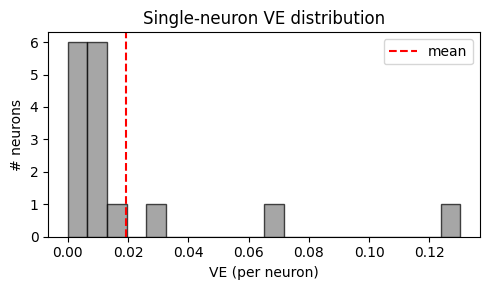

Population VE in 10 PCs: 0.020


In [ ]:
ve_per_neuron, ve_mean = variance_explained.single_neuron_temporal_VE(X, X_hat, aggregate='mean')
ve_median = float(np.median(ve_per_neuron))

print(f'Mean single-neuron VE:   {ve_mean:.3f}')
print(f'Median single-neuron VE: {ve_median:.3f}')

variance_explained.plot_single_neuron_VE_hist(ve_per_neuron)

ve_pop, k_eff = variance_explained.population_VE_in_PCspace(X, X_hat, k=10, center='neuron')
print(f'Population VE in {k_eff} PCs: {ve_pop:.3f}')

variance_explained.plot_population_VE_bar(ve_pop)


In [ ]:
np.sort(ve_per_neuron)

array([0.     , 0.00111, 0.00161, 0.0022 , 0.00284, 0.00502, 0.00656,
       0.0077 , 0.00861, 0.00923, 0.01013, 0.01097, 0.01473, 0.02794,
       0.06898, 0.1303 ])

In [ ]:
# Per-stop breakdown (good for figures)
per_event_df = variance_explained.per_event_breakdown(X, X_hat, event_ids=meta_used['event_id'].to_numpy(), k=10)
print(per_event_df.head())

summary_metrics = {
    'VE_population_PC': ve_pop,
    'VE_single_unit_mean': ve_mean,
    'VE_single_unit_median': ve_median,
    'PCs_used': k_eff
}
print(pd.Series(summary_metrics))


   event_id  n_bins  ve_pop  k_eff  ve_unit_mean
0         0      29 0.00000      8       0.00266
1         1      10 0.01221      6       0.00421
2         2      14 0.01286      6       0.00060
3         3      17 0.00000      5       0.00284
4         4      29 0.01603      6       0.00344
VE_population_PC         0.02025
VE_single_unit_mean      0.01925
VE_single_unit_median    0.00816
PCs_used                10.00000
dtype: float64


## Plot spikes

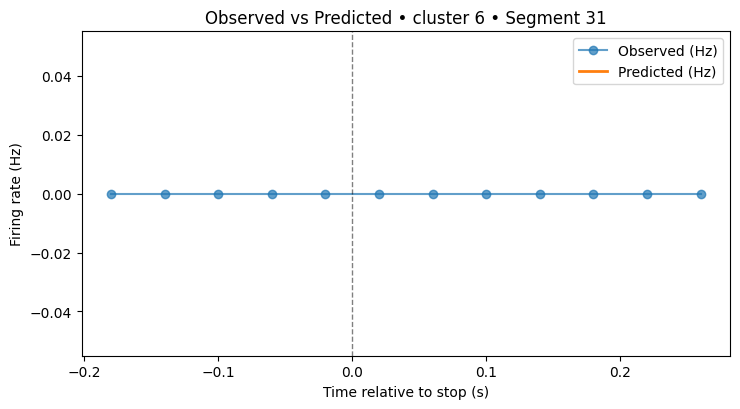

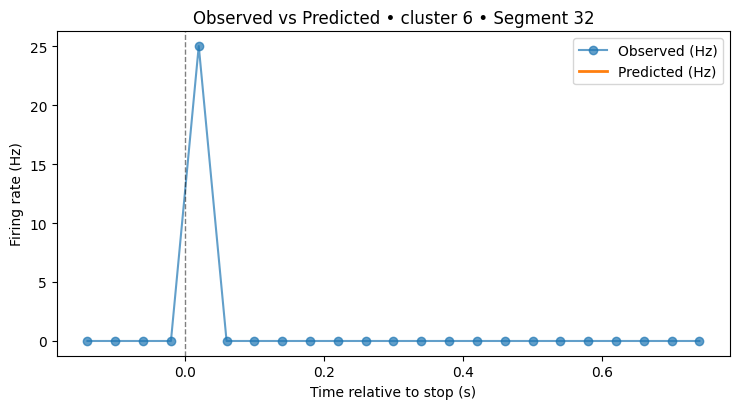

In [ ]:
reload(plot_spikes)

cluster_idx = 6

for event_id in range(30, 33):
    if event_id in meta_used['event_id'].values:
        # If your GLM used offset_log = np.log(exposure_s), you can omit exposure_s:
        plot_spikes.plot_observed_vs_predicted_event(
            binned_feats_sc=binned_feats_sc,
            binned_spikes=binned_spikes,
            meta_used=meta_used,
            offset_log=offset_log,
            model_res=report['results'][cluster_idx],   # GLM for cluster 0
            cluster_idx=cluster_idx,
            seg_id=event_id,
            seg_col='event_id',
            time_col='rel_center'
        )

## Note large coeff

In [ ]:
glm_fit_utils.summarize_large_coeffs(report['coefs_df'], df_X)


,cluster,term,coef,se,p,RR_1sd,abs_beta


## CV

In [ ]:
reload(cv_stop_glm)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_fit.cv_stop_glm' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_glm/glm_fit/cv_stop_glm.py'>

In [ ]:
# groups = meta_used['event_id']  # or your session/stop-window IDs
# scores = cv_stop_glm.cv_score_per_cluster(binned_feats_sc, binned_spikes, offset_log, groups, n_splits=5)
# cv_stop_glm.plot_cv_scores(scores)
# scores

## CCA

In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold

def _zscore(X, eps=1e-12):
    mu = np.nanmean(X, axis=0, keepdims=True)
    sd = np.nanstd(X, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (X - mu) / sd, mu, sd

def _nanmask_pair(X, Y):
    m = np.isfinite(X).all(1) & np.isfinite(Y).all(1)
    return X[m], Y[m], m

def cca_pop_metric_train_test(
    X_tr, Y_tr, X_te, Y_te, *,
    n_components=10,
    standardize=True,
    map_type='diag',          # 'diag' (per-dim gain) or 'full' (least-squares)
    max_iter=1000,
    eps=1e-12
):
    """
    Population comparison in CCA subspace (train/test safe).

    Parameters
    ----------
    X_tr, Y_tr : (n_train, n_neurons)
    X_te, Y_te : (n_test,  n_neurons)
    n_components : number of canonical pairs to keep
    standardize : z-score each view before CCA (recommended)
    map_type : 'diag' maps each canonical dim with a scalar gain learned on train;
               'full' learns an unconstrained linear map between canonical spaces on train.
    Returns
    -------
    out : dict
        {
          've_test': float in [0,1],
          'corrs_train': (k,), canonical correlations on train,
          'corrs_test':  (k,), canonical correlations on test (using train-fitted CCA),
          'k_eff': int, number of dims used,
          'A': mapping matrix in canonical space (k x k),
          'cca': fitted CCA object,
          'mu_sigmas': {(view): (mu, sd)} if standardized
        }
    """
    X_tr, Y_tr, _ = _nanmask_pair(np.asarray(X_tr, float), np.asarray(Y_tr, float))
    X_te, Y_te, _ = _nanmask_pair(np.asarray(X_te, float), np.asarray(Y_te, float))

    # standardize each view (prevents scale dominating CCA)
    mu_sigmas = {}
    if standardize:
        X_tr, mu_x, sd_x = _zscore(X_tr, eps)
        Y_tr, mu_y, sd_y = _zscore(Y_tr, eps)
        X_te = (X_te - mu_x) / sd_x
        Y_te = (Y_te - mu_y) / sd_y
        mu_sigmas = {'X': (mu_x, sd_x), 'Y': (mu_y, sd_y)}

    # fit CCA on TRAIN only
    k = int(n_components)
    cca = CCA(n_components=k, max_iter=max_iter)
    Xc_tr, Yc_tr = cca.fit_transform(X_tr, Y_tr)         # (n_train, k), (n_train, k)

    # canonical correlations on TRAIN
    corrs_tr = np.array([np.corrcoef(Xc_tr[:, i], Yc_tr[:, i])[0, 1] for i in range(Xc_tr.shape[1])])
    # transform TEST into the SAME canonical axes
    Xc_te, Yc_te = cca.transform(X_te, Y_te)

    # canonical correlations on TEST (no re-fit)
    corrs_te = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(Xc_te.shape[1])])

    # learn mapping in canonical space on TRAIN
    if map_type == 'diag':
        # per-dim least-squares gains: minimize ||Xc - A_diag Yc||^2
        gains = []
        for i in range(Xc_tr.shape[1]):
            y = Yc_tr[:, i]
            x = Xc_tr[:, i]
            num = float(np.dot(y, x))
            den = float(np.dot(y, y)) + eps
            gains.append(num / den)
        A = np.diag(gains)
    elif map_type == 'full':
        # unconstrained least squares in canonical space
        # solve Yc_tr @ A ≈ Xc_tr  =>  A = argmin ||Yc_tr A - Xc_tr||
        A, _, _, _ = np.linalg.lstsq(Yc_tr, Xc_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')

    # VE-style score on TEST in the learned canonical subspace
    # 1 - ||Xc_te - A Yc_te||_F^2 / ||Xc_te||_F^2
    X_hat_can_te = Yc_te @ A
    den = float(np.sum(Xc_te**2))
    if not np.isfinite(den) or den <= eps:
        ve_test = 0.0
    else:
        num = float(np.sum((Xc_te - X_hat_can_te)**2))
        ve_test = 1.0 - (num / den)
        ve_test = float(np.clip(ve_test, 0.0, 1.0))

    return {
        've_test': ve_test,
        'corrs_train': corrs_tr,
        'corrs_test': corrs_te,
        'k_eff': int(Xc_tr.shape[1]),
        'A': A,
        'cca': cca,
        'mu_sigmas': mu_sigmas
    }

def kfold_cca_pop_metric(
    X, Y, *, n_components=10, n_splits=5, standardize=True, map_type='diag', rng=0
):
    """
    Convenience K-fold wrapper returning fold-wise VE and canonical correlation spectra.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
    ve_list, corrs_tr_list, corrs_te_list = [], [], []
    for tr, te in kf.split(X):
        out = cca_pop_metric_train_test(
            X[tr], Y[tr], X[te], Y[te],
            n_components=n_components, standardize=standardize, map_type=map_type
        )
        ve_list.append(out['ve_test'])
        corrs_tr_list.append(out['corrs_train'])
        corrs_te_list.append(out['corrs_test'])
    # pad corr arrays if n_components varies (it shouldn’t with sklearn CCA)
    corrs_tr = np.vstack(corrs_tr_list)
    corrs_te = np.vstack(corrs_te_list)
    return {
        've_mean': float(np.mean(ve_list)),
        've_std':  float(np.std(ve_list)),
        'corrs_train_mean': np.nanmean(corrs_tr, axis=0),
        'corrs_test_mean':  np.nanmean(corrs_te, axis=0),
        'corrs_train_all': corrs_tr,
        'corrs_test_all':  corrs_te
    }


In [ ]:
# X, X_hat: (samples, neurons) aligned in time; split by trial/stop for CV!
cv = kfold_cca_pop_metric(
    X, X_hat,
    n_components=10,
    n_splits=5,
    standardize=True,
    map_type='diag'   # try 'full' as a sensitivity check
)

print('CCA-subspace VE (mean±sd):', cv['ve_mean'], cv['ve_std'])
print('Mean canonical correlations (train):', cv['corrs_train_mean'])
print('Mean canonical correlations (test): ', cv['corrs_test_mean'])


CCA-subspace VE (mean±sd): 0.029090078362221616 0.015008781733667223
Mean canonical correlations (train): [0.3873  0.32634 0.21035 0.1886  0.11311 0.0918  0.08127 0.06914 0.05612
 0.04729]
Mean canonical correlations (test):  [0.30967 0.26425 0.17036 0.14298 0.07979 0.05667 0.0565  0.04776 0.03288
 0.02434]


In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## RRR

In [ ]:
import numpy as np
from numpy.linalg import lstsq, svd

def rrr_fit(X_tr, Y_tr, rank, eps=1e-12):
    """
    Fit reduced-rank regression: X ≈ Y @ B,  rank(B) ≤ rank.
    Returns B (features_Y × features_X) and centering stats.
    """
    X_tr = np.asarray(X_tr, float); Y_tr = np.asarray(Y_tr, float)
    mx = X_tr.mean(0, keepdims=True); my = Y_tr.mean(0, keepdims=True)
    Xc = X_tr - mx; Yc = Y_tr - my

    # Full OLS then truncate via SVD (optimal rank-r in Frobenius norm)
    B_ols, *_ = lstsq(Yc, Xc, rcond=None)            # (pY × pX)
    U, s, Vt = svd(B_ols, full_matrices=False)
    r = int(max(1, min(rank, np.sum(s > eps))))
    B_rr = (U[:, :r] @ np.diag(s[:r]) @ Vt[:r, :])    # rank-r projection of B_ols
    return {'B': B_rr, 'mx': mx, 'my': my, 'rank': r}

def rrr_predict(fit, Y):
    Y = np.asarray(Y, float)
    return (Y - fit['my']) @ fit['B'] + fit['mx']

def ve_fro(X, Xhat, eps=1e-12):
    X = np.asarray(X, float); Xhat = np.asarray(Xhat, float)
    num = np.sum((X - Xhat)**2)
    den = np.sum((X - X.mean(0, keepdims=True))**2)
    if not np.isfinite(den) or den <= eps: return 0.0
    ve = 1.0 - num / den
    return float(np.clip(ve, 0.0, 1.0))

from sklearn.model_selection import KFold

def rrr_cv(X, Y, ranks=(1,2,3,5,8,12,16), n_splits=5, rng=0):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
    scores = {r: [] for r in ranks}
    for tr, te in kf.split(X):
        for r in ranks:
            fit = rrr_fit(X[tr], Y[tr], rank=r)
            Xhat_te = rrr_predict(fit, Y[te])
            scores[r].append(ve_fro(X[te], Xhat_te))
    means = {r: float(np.mean(v)) for r, v in scores.items()}
    best_rank = max(means, key=means.get)
    return best_rank, means, scores

# Split by trials/stops, not random bins (to avoid leakage).
best_r, mean_by_r, cv_scores = rrr_cv(X, X_hat, ranks=(1,2,3,5,8,12), n_splits=5, rng=0)
print('Best rank:', best_r, 'CV VE:', mean_by_r[best_r])

# Train final model at best rank on all data, or retrain on a train split and evaluate on held-out:
fit = rrr_fit(X, X_hat, rank=best_r)
Xhat_rr = rrr_predict(fit, X_hat)
ve_total = ve_fro(X, Xhat_rr)
print('RRR VE (all data, optimistic):', ve_total)


Best rank: 12 CV VE: 0.005983391221127898
RRR VE (all data, optimistic): 0.0071999180236590465


## CCA shuffle

In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA

def cca_shuffle_test(X, Y, n_components=10, n_splits=100, shuffle_axis=0, random_state=0):
    """
    Permutation test for canonical correlations.

    Parameters
    ----------
    X, Y : arrays (samples × neurons), same shape
    n_components : # of CCA dimensions to compute
    n_splits : number of permutations
    shuffle_axis : 0 = shuffle rows (samples/trials), 1 = shuffle cols (neurons)
    random_state : reproducibility

    Returns
    -------
    corrs_real : array, canonical correlations from true data
    thresh : array, 95th percentile across shuffles for each dim
    sig_dims : list, indices of significant canonical dims
    """
    rng = np.random.default_rng(random_state)

    # fit on true data
    cca = CCA(n_components=n_components, max_iter=1000)
    Xc, Yc = cca.fit_transform(X, Y)
    corrs_real = np.array([np.corrcoef(Xc[:, i], Yc[:, i])[0, 1] for i in range(n_components)])

    # shuffle null
    corrs_shuff = []
    for _ in range(n_splits):
        if shuffle_axis == 0:
            Y_perm = rng.permutation(Y)      # shuffle rows
        else:
            Y_perm = Y.copy()
            rng.shuffle(Y_perm.T)           # shuffle columns independently
        Xs, Ys = cca.fit_transform(X, Y_perm)
        corrs = [np.corrcoef(Xs[:, i], Ys[:, i])[0, 1] for i in range(n_components)]
        corrs_shuff.append(corrs)
    corrs_shuff = np.vstack(corrs_shuff)

    # significance threshold per dim
    thresh = np.percentile(corrs_shuff, 95, axis=0)
    sig_dims = [i for i, c in enumerate(corrs_real) if c > thresh[i]]

    return corrs_real, thresh, sig_dims

corrs_real, thresh, sig_dims = cca_shuffle_test(X, X_hat, n_components=10, n_splits=100)

print("Canonical correlations:", corrs_real)
print("95% shuffle thresholds:", thresh)
print("Significant dims:", sig_dims)


KeyboardInterrupt: 

## pipeline

In [ ]:
# population_latent_benchmark.py
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Iterable, Dict, Any, Tuple, List
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold
from numpy.linalg import lstsq, svd
import matplotlib.pyplot as plt

# ---------- small utils ----------
def _zscore(A: np.ndarray, eps: float = 1e-12) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    mu = np.nanmean(A, axis=0, keepdims=True)
    sd = np.nanstd(A, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (A - mu) / sd, mu, sd

def _fro_ve(X: np.ndarray, Xhat: np.ndarray, eps: float = 1e-12) -> float:
    num = np.sum((X - Xhat) ** 2)
    den = np.sum((X - np.mean(X, axis=0, keepdims=True)) ** 2)
    if not np.isfinite(den) or den <= eps:
        return 0.0
    ve = 1.0 - (num / den)
    return float(np.clip(ve, 0.0, 1.0))

def _safe_mask_pair(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    m = np.isfinite(X).all(1) & np.isfinite(Y).all(1)
    return X[m], Y[m], m

# ---------- RRR ----------
def rrr_fit(X_tr: np.ndarray, Y_tr: np.ndarray, rank: int, eps: float = 1e-12) -> Dict[str, Any]:
    X_tr = np.asarray(X_tr, float); Y_tr = np.asarray(Y_tr, float)
    mx = X_tr.mean(0, keepdims=True); my = Y_tr.mean(0, keepdims=True)
    Xc = X_tr - mx; Yc = Y_tr - my
    B_ols, *_ = lstsq(Yc, Xc, rcond=None)               # (pY × pX)
    U, s, Vt = svd(B_ols, full_matrices=False)
    r = int(max(1, min(rank, np.sum(s > eps))))
    B_rr = U[:, :r] @ np.diag(s[:r]) @ Vt[:r, :]
    return {'B': B_rr, 'mx': mx, 'my': my, 'rank': r}

def rrr_predict(fit: Dict[str, Any], Y: np.ndarray) -> np.ndarray:
    return (np.asarray(Y, float) - fit['my']) @ fit['B'] + fit['mx']

def rrr_cv(X: np.ndarray, Y: np.ndarray, groups: np.ndarray,
           ranks: Iterable[int] = (1, 2, 3, 5, 8, 12, 16),
           n_splits: int = 5, rng: int = 0) -> Dict[str, Any]:
    gkf = GroupKFold(n_splits=n_splits)
    ranks = list(ranks)
    ve_mat = {r: [] for r in ranks}
    for tr_idx, te_idx in gkf.split(X, groups=groups):
        for r in ranks:
            fit = rrr_fit(X[tr_idx], Y[tr_idx], rank=r)
            Xhat_te = rrr_predict(fit, Y[te_idx])
            ve_mat[r].append(_fro_ve(X[te_idx], Xhat_te))
    ve_mean = {r: float(np.mean(v)) for r, v in ve_mat.items()}
    best_rank = max(ve_mean, key=ve_mean.get)
    return {'ve_by_rank': ve_mean, 'best_rank': best_rank, 'cv_scores': ve_mat}

# ---------- CCA (train/test safe) ----------
def cca_train_test(X_tr: np.ndarray, Y_tr: np.ndarray,
                   X_te: np.ndarray, Y_te: np.ndarray,
                   n_components: int = 10, standardize: bool = True,
                   map_type: str = 'diag', max_iter: int = 1000,
                   eps: float = 1e-12) -> Dict[str, Any]:
    if standardize:
        X_tr, mux, sdx = _zscore(X_tr); X_te = (X_te - mux) / sdx
        Y_tr, muy, sdy = _zscore(Y_tr); Y_te = (Y_te - muy) / sdy
    cca = CCA(n_components=int(n_components), max_iter=max_iter)
    Xc_tr, Yc_tr = cca.fit_transform(X_tr, Y_tr)
    Xc_te, Yc_te = cca.transform(X_te, Y_te)

    corrs_tr = np.array([np.corrcoef(Xc_tr[:, i], Yc_tr[:, i])[0, 1] for i in range(Xc_tr.shape[1])])
    corrs_te = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(Xc_te.shape[1])])

    if map_type == 'diag':
        gains = []
        for i in range(Xc_tr.shape[1]):
            num = float(np.dot(Yc_tr[:, i], Xc_tr[:, i]))
            den = float(np.dot(Yc_tr[:, i], Yc_tr[:, i])) + eps
            gains.append(num / den)
        A = np.diag(gains)
    elif map_type == 'full':
        A, *_ = lstsq(Yc_tr, Xc_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')

    Xc_hat_te = Yc_te @ A
    den = float(np.sum(Xc_te ** 2))
    ve_te = 0.0 if den <= eps else float(np.clip(1.0 - np.sum((Xc_te - Xc_hat_te) ** 2) / den, 0.0, 1.0))
    return {'corrs_train': corrs_tr, 'corrs_test': corrs_te, 've_test': ve_te, 'A': A, 'cca': cca}

def cca_shuffle_test_on_test(X_te: np.ndarray, Y_te: np.ndarray, cca_obj: CCA,
                             n_components: int, n_shuffles: int = 100,
                             rng: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    # Use fixed CCA axes (trained on train) to avoid leakage
    rng = np.random.default_rng(rng)
    Xc_te, Yc_te = cca_obj.transform(X_te, Y_te)
    k = int(n_components)
    corrs_real = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(k)])
    null = []
    for _ in range(n_shuffles):
        Yp = rng.permutation(Y_te)  # row-shuffle on test
        _, Yc_perm = cca_obj.transform(X_te, Yp)
        null.append([np.corrcoef(Xc_te[:, i], Yc_perm[:, i])[0, 1] for i in range(k)])
    null = np.vstack(null)
    thresh = np.percentile(null, 95, axis=0)
    return corrs_real, thresh

# ---------- FA latent metric ----------
def fa_train_test(X_tr: np.ndarray, Y_tr: np.ndarray,
                  X_te: np.ndarray, Y_te: np.ndarray,
                  n_factors: int = 8, standardize: bool = True,
                  map_type: str = 'full', eps: float = 1e-12) -> Dict[str, Any]:
    if standardize:
        X_tr, mux, sdx = _zscore(X_tr); X_te = (X_te - mux) / sdx
        Y_tr, muy, sdy = _zscore(Y_tr); Y_te = (Y_te - muy) / sdy
    fa = FactorAnalysis(n_components=int(n_factors), rotation=None)
    Zx_tr = fa.fit_transform(X_tr); Zx_te = fa.transform(X_te)
    Zy_tr = fa.transform(Y_tr);    Zy_te = fa.transform(Y_te)
    if map_type == 'diag':
        gains = []
        for i in range(Zx_tr.shape[1]):
            den = float(np.dot(Zy_tr[:, i], Zy_tr[:, i])) + eps
            gains.append(float(np.dot(Zy_tr[:, i], Zx_tr[:, i])) / den)
        A = np.diag(gains)
    elif map_type == 'full':
        A, *_ = lstsq(Zy_tr, Zx_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')
    Zx_hat_te = Zy_te @ A
    den = float(np.sum((Zx_te - Zx_te.mean(0)) ** 2))
    ve_lat = 0.0 if den <= eps else float(np.clip(1.0 - np.sum((Zx_te - Zx_hat_te) ** 2) / den, 0.0, 1.0))
    # per-factor test correlations
    corrs = []
    for i in range(Zx_te.shape[1]):
        xi, yi = Zx_te[:, i], Zx_hat_te[:, i]
        si = np.std(xi); sj = np.std(yi)
        corrs.append(0.0 if si < 1e-12 or sj < 1e-12 else float(np.corrcoef(xi, yi)[0, 1]))
    return {'ve_latent_test': ve_lat, 'corrs_latent_test': np.array(corrs), 'A': A, 'fa': fa}

# ---------- Main benchmark ----------
@dataclass
class BenchmarkResult:
    fa_ve_mean: float
    fa_ve_std: float
    cca_ve_mean: float
    cca_ve_std: float
    cca_corr_test_mean: np.ndarray
    cca_corr_thresh95: np.ndarray
    rrr_best_rank: int
    rrr_ve_by_rank: Dict[int, float]
    plots: Dict[str, Any]    # matplotlib Figure objects

def population_latent_benchmark(X: np.ndarray, Y: np.ndarray, trial_ids: np.ndarray,
                                *, n_splits: int = 5,
                                fa_factors: int = 8,
                                cca_components: int = 10,
                                rrr_ranks: Iterable[int] = (1, 2, 3, 5, 8, 12, 16),
                                shuffle_reps: int = 100,
                                rng: int = 0) -> BenchmarkResult:
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    assert X.shape == Y.shape, 'X and Y must have same shape'
    groups = np.asarray(trial_ids)

    gkf = GroupKFold(n_splits=n_splits)
    fa_ves, cca_ves, cca_corrs_list, cca_thresh_list = [], [], [], []

    # RRR CV across ranks (once; GroupKFold inside)
    rrr = rrr_cv(X, Y, groups=groups, ranks=rrr_ranks, n_splits=n_splits, rng=rng)

    # Fold loop for FA & CCA
    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, groups=groups)):
        Xtr, Ytr = X[tr_idx], Y[tr_idx]
        Xte, Yte = X[te_idx], Y[te_idx]

        # FA latent VE
        fa_out = fa_train_test(Xtr, Ytr, Xte, Yte, n_factors=fa_factors, standardize=True, map_type='full')
        fa_ves.append(fa_out['ve_latent_test'])

        # CCA subspace VE + test corr spectrum + shuffle baseline
        cca_out = cca_train_test(Xtr, Ytr, Xte, Yte, n_components=cca_components, standardize=True, map_type='diag')
        cca_ves.append(cca_out['ve_test'])

        corrs_real, thresh = cca_shuffle_test_on_test(Xte, Yte, cca_out['cca'],
                                                      n_components=cca_components,
                                                      n_shuffles=shuffle_reps, rng=rng + fold)
        cca_corrs_list.append(corrs_real)
        cca_thresh_list.append(thresh)

    fa_ve_mean, fa_ve_std = float(np.mean(fa_ves)), float(np.std(fa_ves))
    cca_ve_mean, cca_ve_std = float(np.mean(cca_ves)), float(np.std(cca_ves))
    cca_corr_test_mean = np.mean(np.vstack(cca_corrs_list), axis=0)
    cca_corr_thresh95 = np.mean(np.vstack(cca_thresh_list), axis=0)

    # ---------- Plots ----------
    figs: Dict[str, Any] = {}

    # 1) CCA spectrum vs shuffle
    fig1 = plt.figure(figsize=(4, 3))
    x = np.arange(1, len(cca_corr_test_mean) + 1)
    plt.plot(x, cca_corr_test_mean, marker='o', label='Test corr')
    plt.plot(x, cca_corr_thresh95, linestyle='--', label='Shuffle 95%')
    plt.xlabel('Canonical component')
    plt.ylabel('Correlation')
    plt.title('CCA test spectrum')
    plt.legend()
    plt.tight_layout()
    figs['cca_spectrum'] = fig1

    # 2) VE summary bars
    fig2 = plt.figure(figsize=(4, 3))
    names = ['FA-latent VE', 'CCA-VE', f'RRR-VE@r={rrr["best_rank"]}']
    vals = [fa_ve_mean, cca_ve_mean, rrr['ve_by_rank'][rrr['best_rank']]]
    y = np.arange(len(names))
    plt.bar(y, vals)
    plt.xticks(y, names, rotation=20)
    plt.ylim(0, max(0.01, max(vals) * 1.2))
    plt.ylabel('Variance explained')
    plt.title('Population VE summary')
    plt.tight_layout()
    figs['ve_summary'] = fig2

    # 3) RRR VE vs rank
    fig3 = plt.figure(figsize=(4, 3))
    rs = sorted(rrr['ve_by_rank'].keys())
    vrs = [rrr['ve_by_rank'][r] for r in rs]
    plt.plot(rs, vrs, marker='o')
    plt.xlabel('Rank')
    plt.ylabel('CV VE')
    plt.title('RRR VE vs rank')
    plt.tight_layout()
    figs['rrr_curve'] = fig3

    return BenchmarkResult(
        fa_ve_mean=fa_ve_mean,
        fa_ve_std=fa_ve_std,
        cca_ve_mean=cca_ve_mean,
        cca_ve_std=cca_ve_std,
        cca_corr_test_mean=cca_corr_test_mean,
        cca_corr_thresh95=cca_corr_thresh95,
        rrr_best_rank=rrr['best_rank'],
        rrr_ve_by_rank=rrr['ve_by_rank'],
        plots=figs
    )


In [ ]:
# X = observed (samples × neurons)
# X_hat = predictions (same shape)
# trial_ids = your per-row trial/segment ids
res = population_latent_benchmark(X, X_hat, trial_ids,
                                  n_splits=5,
                                  fa_factors=8,
                                  cca_components=10,
                                  rrr_ranks=(1,2,3,5,8,12,16),
                                  shuffle_reps=100,
                                  rng=0)

print('FA-latent VE (mean±sd):', res.fa_ve_mean, res.fa_ve_std)
print('CCA-VE (mean±sd):      ', res.cca_ve_mean, res.cca_ve_std)
print('RRR best rank:', res.rrr_best_rank)
print('RRR VE by rank:', res.rrr_ve_by_rank)

# show or save figures
for name, fig in res.plots.items():
    fig.show()           # or fig.savefig(f'{name}.png', dpi=200, bbox_inches='tight')


NameError: name 'trial_ids' is not defined

## CCA latent

/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_5636/1959056748.py:113: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sems  = gb.apply(lambda g: pd.Series({
/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_5636/1959056748.py:197: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # or fig.savefig(f'shared_manifold_{i}.png', dpi=200, bbox_inches='tight')


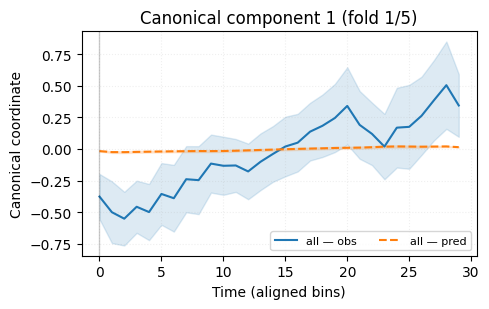

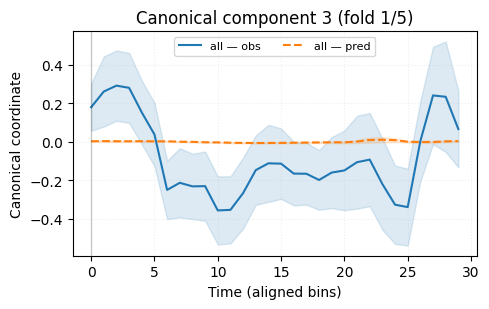

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold

def _zscore(A, eps=1e-12):
    mu = np.nanmean(A, axis=0, keepdims=True)
    sd = np.nanstd(A, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (A - mu) / sd, mu, sd

def _sem(a, axis=0):
    a = np.asarray(a, float)
    n = np.sum(np.isfinite(a), axis=axis)
    n = np.maximum(n, 1)
    return np.nanstd(a, axis=axis) / np.sqrt(n)

def _smooth_1d(x, k=1):
    if k <= 1: 
        return x
    k = int(k)
    kern = np.ones(k) / k
    return np.convolve(x, kern, mode='same')

def visualize_shared_manifold(
    X, Y, trial_ids, time_idx, cond=None, *,
    n_components=3,
    n_splits=5,
    which_fold=0,            # pick which fold to visualize
    standardize=True,
    smooth_bins=1,           # boxcar smoothing across time for the mean curves
    colors=('C0','C1'),      # (observed, predicted)
    show_phase_plane=True
):
    """
    Fit CCA on TRAIN trials, project TEST trials into canonical space, and plot
    observed vs predicted trajectories (mean±SEM) over time for the first components.

    Parameters
    ----------
    X, Y : arrays (samples × neurons), same shape
    trial_ids : array (samples,)
    time_idx : array (samples,) time within aligned window (e.g., -1.5..+1.5s or bin index)
    cond : optional array-like (samples,), categorical condition label per sample
    n_components : # of canonical components to visualize
    n_splits : GroupKFold splits by trial_ids
    which_fold : index of fold to visualize (0..n_splits-1)
    standardize : z-score each view prior to CCA
    smooth_bins : boxcar width for smoothing mean curves (in bins)
    colors : tuple for (observed, predicted) lines
    show_phase_plane : also plot Comp1 vs Comp2 phase-plane (obs vs pred)
    """
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    assert X.shape == Y.shape, "X and Y must have same shape"

    # group-wise split by trials
    trial_ids = np.asarray(trial_ids)
    time_idx = np.asarray(time_idx)
    if cond is None:
        cond = np.array(['all'] * len(time_idx))
    else:
        cond = np.asarray(cond)

    gkf = GroupKFold(n_splits=n_splits)
    splits = list(gkf.split(X, groups=trial_ids))
    tr_idx, te_idx = splits[which_fold]

    Xtr, Ytr = X[tr_idx], Y[tr_idx]
    Xte, Yte = X[te_idx], Y[te_idx]
    trial_te = trial_ids[te_idx]
    time_te  = time_idx[te_idx]
    cond_te  = cond[te_idx]

    # standardize each view
    if standardize:
        Xtr, mux, sdx = _zscore(Xtr)
        Ytr, muy, sdy = _zscore(Ytr)
        Xte = (Xte - mux) / sdx
        Yte = (Yte - muy) / sdy

    # fit CCA on TRAIN only
    k = int(n_components)
    cca = CCA(n_components=k, max_iter=1000)
    Xc_tr, Yc_tr = cca.fit_transform(Xtr, Ytr)
    Xc_te, Yc_te = cca.transform(Xte, Yte)

    # package canonical coordinates for TEST into a tidy DataFrame
    dfs = []
    for view_name, Z in [('obs', Xc_te), ('pred', Yc_te)]:
        df = pd.DataFrame({
            'trial': trial_te,
            'time': time_te,
            'cond': cond_te,
        })
        for i in range(k):
            df[f'can{i+1}'] = Z[:, i]
        df['view'] = view_name
        dfs.append(df)
    df_all = pd.concat(dfs, axis=0, ignore_index=True)

    # aggregate mean ± SEM over trials at each time, by condition & view
    # we align on time bins; ensure numeric sorting
    df_all = df_all.sort_values(['cond', 'view', 'time'])
    results = {}
    for c in np.unique(cond_te):
        results[c] = {}
        dsub = df_all[df_all['cond'] == c]
        # group by time & view, compute mean/sem per component
        gb = dsub.groupby(['view', 'time'])
        means = gb.mean(numeric_only=True)
        sems  = gb.apply(lambda g: pd.Series({
            **{f'can{i+1}': _sem(g[f'can{i+1}'].values) for i in range(k)}
        }))
        # pivot to have time index, separate views
        means = means.reset_index().pivot(index='time', columns='view', values=[f'can{i+1}' for i in range(k)])
        sems  = sems.reset_index().pivot(index='time', columns='view', values=[f'can{i+1}' for i in range(k)])
        # sort by time
        means = means.sort_index()
        sems  = sems.sort_index()
        results[c]['mean'] = means
        results[c]['sem']  = sems

    # --- plotting ---
    figs = []
    # 1) Trajectories for each canonical component
    for i in range(k):
        fig = plt.figure(figsize=(5, 3.2))
        ax = plt.gca()
        for j, c in enumerate(results.keys()):
            means = results[c]['mean'][(f'can{i+1}',)]
            sems  = results[c]['sem'][(f'can{i+1}',)]
            for view_idx, view in enumerate(['obs','pred']):
                y = means[view].values
                s = sems[view].values
                if smooth_bins > 1:
                    y = _smooth_1d(y, smooth_bins)
                    s = _smooth_1d(s, smooth_bins)
                t = means.index.values
                ax.plot(t, y, label=f'{c} — {view}', 
                        linestyle='-' if view=='obs' else '--',
                        color=colors[view_idx])
                ax.fill_between(t, y - s, y + s, alpha=0.15, color=colors[view_idx])
        ax.set_title(f'Canonical component {i+1} (fold {which_fold+1}/{n_splits})')
        ax.set_xlabel('Time (aligned bins)')
        ax.set_ylabel('Canonical coordinate')
        ax.legend(ncol=2, fontsize=8)
        ax.axvline(0, color='k', linewidth=1, alpha=0.2)
        ax.grid(alpha=0.2, linestyle=':')
        plt.tight_layout()
        figs.append(fig)

    # 2) Phase-plane plot (Comp1 vs Comp2)
    if show_phase_plane and k >= 2:
        fig = plt.figure(figsize=(4, 4))
        ax = plt.gca()
        for j, c in enumerate(results.keys()):
            m1 = results[c]['mean'][('can1',)]
            m2 = results[c]['mean'][('can2',)]
            t = m1.index.values
            for view_idx, view in enumerate(['obs','pred']):
                x = m1[view].values
                y = m2[view].values
                if smooth_bins > 1:
                    x = _smooth_1d(x, smooth_bins)
                    y = _smooth_1d(y, smooth_bins)
                ax.plot(x, y, label=f'{c} — {view}',
                        linestyle='-' if view=='obs' else '--',
                        color=colors[view_idx])
                # mark time zero if present
                if 0 in t:
                    idx0 = np.where(t==0)[0]
                    if len(idx0): 
                        ax.scatter(x[idx0[0]], y[idx0[0]], s=30, color=colors[view_idx])
        ax.set_xlabel('Can1')
        ax.set_ylabel('Can2')
        ax.set_title(f'Phase plane (fold {which_fold+1}/{n_splits})')
        ax.legend(ncol=2, fontsize=8)
        ax.grid(alpha=0.2, linestyle=':')
        plt.tight_layout()
        figs.append(fig)

    return {'figs': figs, 'cca': cca}

# X, X_hat: (samples, neurons)
# trial_ids: trial/segment identifier per row (for GroupKFold)
# time_idx: bin index (e.g., -30..+30) or seconds relative to event
# cond: optional labels (e.g., visibility state or stop outcome)
out = visualize_shared_manifold(
    X, X_hat, trial_ids, data['new_bin'], cond=None,
    n_components=3, n_splits=5, which_fold=0,
    standardize=True, smooth_bins=3, show_phase_plane=True
)
# Show or save figures:
for i, fig in enumerate(out['figs'], 1):
    fig.show()  # or fig.savefig(f'shared_manifold_{i}.png', dpi=200, bbox_inches='tight')


In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA

def population_ve_cca(X, Y, n_components=10):
    """
    Canonical correlation analysis between observed (X) and predicted (Y).

    Parameters
    ----------
    X : array, shape (samples, neurons)
    Y : array, shape (samples, neurons) -- same shape as X
    n_components : number of canonical pairs to compute

    Returns
    -------
    corrs : array of canonical correlations (length n_components)
    mean_corr : average canonical correlation across components
    """
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    assert X.shape == Y.shape, 'X and Y must have same shape'

    cca = CCA(n_components=n_components, max_iter=1000)
    Xc, Yc = cca.fit_transform(X, Y)
    corrs = [np.corrcoef(Xc[:,i], Yc[:,i])[0,1] for i in range(Xc.shape[1])]
    return np.array(corrs), np.mean(corrs)

corrs, mean_corr = population_ve_cca(X, X_hat, n_components=10)
print('Canonical correlations:', corrs)
print('Mean correlation:', mean_corr)

Canonical correlations: [0.65553 0.54313 0.43566 0.40904 0.36941 0.35522 0.3469  0.32938 0.30655
 0.30343]
Mean correlation: 0.40542476614000866


# tuning curve

In [ ]:
reload(plot_tuning_func)

cluster_id = 10
model_res = report['results'][cluster_id]
var = 'captured'

exposure_s = np.exp(offset_log)
# make empirical curve
tc_emp = plot_tuning_func.empirical_tuning_curve(
    binned_spikes=binned_spikes[cluster_id].to_numpy(),
    predictor_vals=binned_feats[var].to_numpy(),
    exposure_s=exposure_s,
    nbins=20
)

# make GLM curve
tc_glm = plot_tuning_func.glm_tuning_curve(
    model_res, df_X,
    var=var,
    offset_log=offset_log,
    average='marginal',
    weights=exposure_s,                 # time-weighted average rate (recommended)
    return_ci=True
)

# overlay
plot_tuning_func.overlay_tuning_curves(tc_emp, tc_glm, xcol=var,
                      title=f'Unit {cluster_id}: {var} tuning')


KeyError: 'nxt_ff_in_memory'

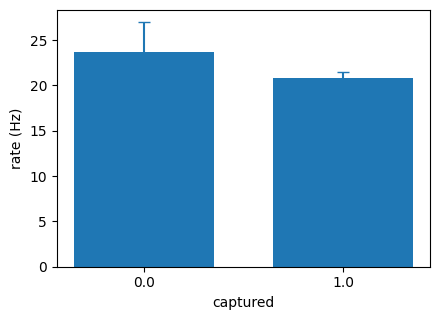

In [ ]:
plot_tuning_func.plot_tuning_with_ci(tc_glm, xcol='captured', ycol='rate_hz')
plt.show()

# plot pred_vs_obs

In [ ]:
cluster_id = 5
cv_stop_glm.plot_pred_vs_obs(report['results'][cluster_id], df_X, binned_spikes[cluster_id], offset_log)

# check fr

In [ ]:
dt = 0.04
rates = binned_spikes.sum(axis=0) / (len(binned_spikes) * dt)
# rates is a Series indexed by unit, in Hz
rates

0    12.02585
1    10.69791
2     5.31796
3    26.58051
4     6.17485
       ...   
73    2.65898
74    1.25201
75    6.15780
76    1.13890
77    2.68067
Length: 78, dtype: float64

In [ ]:
import pandas as pd

def firing_rates_from_df(spikes_df, time_col='time', cluster_col='cluster'):
    start_s = spikes_df[time_col].min()
    end_s = spikes_df[time_col].max()
    duration = end_s - start_s

    counts = spikes_df.groupby(cluster_col).size()
    rates_hz = counts / duration
    return rates_hz.rename('rate_hz').reset_index()

firing_rates_from_df(pn.spikes_df)

,cluster,rate_hz
0,0,12.63688
1,1,13.55206
2,2,6.80934
3,3,24.32848
4,4,9.08267
...,...,...
73,73,2.85900
74,74,3.02180
75,75,6.15042
76,76,2.29094


# Inspect data

In [ ]:
new_seg_info

,stop_id,point_index,time,stop_id_start_time,stop_id_end_time,stop_id_duration,stop_cluster_id,stop_cluster_size,stop_time,prev_time,next_time,new_seg_start_time,new_seg_end_time,is_truncated_pre,is_truncated_post,n_pre_bins,n_post_bins,new_seg_duration,ok_window,captured,event_id,event_time
4,4,1457,24.29708,24.28047,24.69550,0.41506,4,1,24.28047,22.12254,28.71259,24.12047,25.28047,False,False,4,25,1.16000,True,1.00000,4,24.28047
5,5,1725,28.72926,28.71259,29.14425,0.43158,5,2,28.71259,24.69550,29.45966,28.55259,29.07259,False,True,4,9,0.52000,False,0.00000,5,28.71259
6,6,1770,29.47625,29.45966,30.32287,0.86324,5,2,29.45966,29.14425,31.76704,29.33966,30.45966,True,False,3,25,1.12000,True,1.00000,6,29.45966
12,12,2361,39.25359,39.23701,39.85115,0.61428,10,2,39.23701,38.60616,40.14994,39.03701,39.67701,False,True,5,11,0.64000,False,0.00000,12,39.23701
13,13,2416,40.16656,40.14994,41.06298,0.91303,10,2,40.14994,39.85115,42.65644,40.02994,41.14994,True,False,3,25,1.12000,True,1.00000,13,40.14994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,1337,215909,3576.09418,3576.07759,3576.82459,0.74693,1052,2,3576.07759,3575.64598,3578.10298,3575.91759,3577.07759,False,False,4,25,1.16000,True,1.00000,1337,3576.07759
1339,1339,216132,3579.76269,3579.74603,3580.01178,0.26561,1054,1,3579.74603,3578.78333,3583.23209,3579.58603,3580.74603,False,False,4,25,1.16000,True,1.00000,1339,3579.74603
1340,1340,216344,3583.24870,3583.23209,3583.89605,0.66397,1055,1,3583.23209,3580.01178,3587.41554,3583.07209,3584.23209,False,False,4,25,1.16000,True,1.00000,1340,3583.23209
1342,1342,216695,3589.05859,3589.04193,3589.20800,0.16614,1057,1,3589.04193,3588.16222,3591.31616,3588.88193,3590.04193,False,False,4,25,1.16000,True,1.00000,1342,3589.04193


<Axes: xlabel='n_pre_bins', ylabel='Count'>

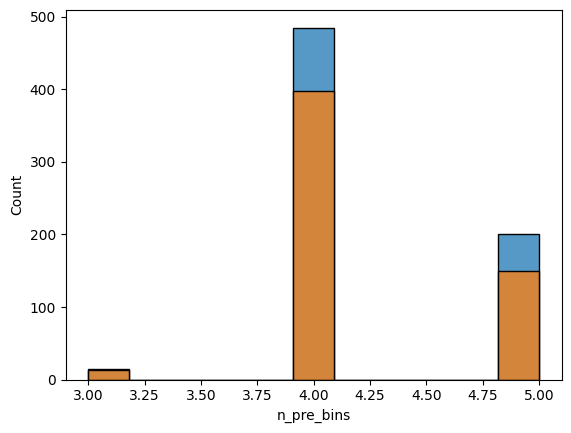

In [ ]:
seg_sub = new_seg_info[new_seg_info['captured'] > 0]
sns.histplot(new_seg_info['n_pre_bins'])
sns.histplot(seg_sub['n_pre_bins'])

<Axes: xlabel='n_post_bins', ylabel='Count'>

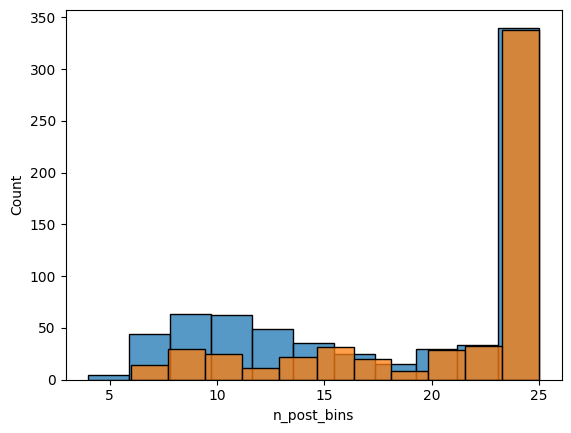

In [ ]:
sns.histplot(new_seg_info['n_post_bins'])
sns.histplot(seg_sub['n_post_bins'])

# plot_spaghetti_per_stop

## run func

In [ ]:
cols = ['event_id', 'rel_center', 't_left', 't_right']
binned_spikes2 = binned_spikes.copy()
binned_spikes2[cols] = meta_used[cols]

In [ ]:
binned_spikes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,2,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,2,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16129,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,2,0,0,0,0,0
16130,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
16131,0,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0
16132,0,1,2,1,2,0,1,2,0,0,0,1,0,0,0,0,0,1,0,2,2,2,0,0,0,...,2,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
# choose a unit column by name or int (e.g., 3)
# unit_col = 3  # or '3' if your columns are strings
for unit_col in binned_spikes.columns:
    df_rate = plot_spikes.make_rate_df_from_binned(binned_spikes2, unit_col)

    # plot (with gentle smoothing and pre-stop baseline subtraction)
    fig, ax, n = plot_spikes.plot_spaghetti_per_stop(
        df_rate,
        smooth_sigma_s=0.08,          # ~80 ms sigma (auto-converted to bins)
        # baseline_window=(-0.5, -0.1), # subtract mean pre-stop activity
        baseline_window=None,
        max_stops=None,               # or an int to limit how many lines
        median_label='median (all stops)',
        title=f'Unit {unit_col}: rate per stop'
    )
    plt.show()
    print(f'Plotted {n} stops.')
    
    break
    


# Hyperparam tuning (try different configs)

## just elastic net

In [ ]:
cluster_df

,event_id,rel_center,event_cluster_id,event_cluster_size,is_clustered,event_cluster_size,event_idx_in_cluster,event_is_first_in_cluster,event_is_last_in_cluster,cluster_progress,cluster_progress_c,cluster_progress_c2,has_prev,has_next,prev_gap_s,next_gap_s,prev_gap_s_z,next_gap_s_z,cluster_start_time,cluster_end_time,cluster_duration_s,cluster_duration_s_z,time_from_cluster_start_s,time_until_cluster_end_s,log_n_events_in_cluster_z,cluster_rel_time_s,cluster_rel_time_s_z
0,4,-0.14000,4,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.14000,0.00000
1,4,-0.10000,4,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.10000,0.00000
2,4,-0.06000,4,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.06000,0.00000
3,4,-0.02000,4,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.02000,0.00000
4,4,0.02000,4,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16129,1344,0.82000,1059,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.82000,0.00000
16130,1344,0.86000,1059,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.86000,0.00000
16131,1344,0.90000,1059,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.90000,0.00000
16132,1344,0.94000,1059,1.00000,0,1.00000,1.00000,1,1,0.50000,0.00000,0.00000,0,0,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.94000,0.00000


In [ ]:
reload(stop_glm_fit)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_fit.stop_glm_fit' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_glm/glm_fit/stop_glm_fit.py'>

In [ ]:


res = stop_glm_fit.glm_mini_report(
    df_X, df_Y, offset_log,
    regularization='elasticnet',
    # alpha_grid=(0.05, 0.1, 0.2, 0.5, 1.0),
    # l1_wt_grid=(0.75, 0.5, 0.25, 0.0),
    alpha_grid=(0.1, 0.2),
    l1_wt_grid=(0.75, 0.5),
    groups=cluster_df['event_cluster_id'].values
)

Fitting cluster 1/78: 0 ...
    best hyperparams: alpha=0.1, l1_wt=0.75, score=-3029.463


AttributeError: module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_fit.glm_fit_utils' has no attribute '_flag_and_update_metrics_row'

In [ ]:
res.keys()

In [ ]:
res['cv_tables_df']

In [ ]:
res['metrics_df']

In [ ]:
res['figures']['rr_hist']

In [ ]:
# all chosen alphas
print(res['metrics_df']['alpha'].value_counts())

# mean/median chosen alpha across clusters
print(res['metrics_df']['alpha'].agg(['mean','median']))

# joint distribution of alpha × l1_wt
pd.crosstab(res['metrics_df']['alpha'], res['metrics_df']['l1_wt'])


## configs (systematic)

In [ ]:
configs = [
    # 1) Ridge (ultra-light grid) ─ combos: ~18
    dict(name='Poisson_Ridge_ultra',
         regularization='elasticnet',
         alpha_grid=tuple(np.concatenate([
             np.logspace(-6, -4.7, 6),   # 1e-6 … ~2e-5
             np.logspace(-4.7, -2.3, 12) # ~2e-5 … 5e-3
         ])),
         l1_wt_grid=(0.0,),                 # pure L2
         cv_metric='loglik', n_splits=5, cov_type='HC1',
         refit_on_support=False),

    # 2) Lasso (ultra-light grid) + refit ─ combos: ~16
    dict(name='Poisson_Lasso_ultra_refit',
         regularization='elasticnet',
         alpha_grid=tuple(np.concatenate([
             np.logspace(-6, -4.7, 6),   # 1e-6 … ~2e-5
             np.logspace(-4.7, -3.3, 10) # ~2e-5 … 5e-4
         ])),
         l1_wt_grid=(1.0,),                 # pure L1
         cv_metric='loglik', n_splits=5, cov_type='HC1',
         refit_on_support=True),
    
    
    # 0) Plain Poisson MLE, robust SEs (baseline) ─ combos: 1
    dict(name='Poisson_MLE_HC3',
         regularization='none',
         alpha_grid=(0.0,), l1_wt_grid=(0.0,),
         cv_metric='loglik', n_splits=5, cov_type='HC3',
         refit_on_support=False),

]


In [ ]:
# configs = [
#     # 0) Plain Poisson MLE, robust SEs (baseline)  ─ combos: 1
#     dict(name='Poisson_MLE_HC3',
#          regularization='none',
#          alpha_grid=(0.0,), l1_wt_grid=(0.0,),
#          cv_metric='loglik', n_splits=5, cov_type='HC3',
#          refit_on_support=False),

#     # 1) Ridge (fine grid) ─ combos: 20
#     dict(name='Poisson_Ridge_fine',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 2, 20)),
#          l1_wt_grid=(0.0,),                 # pure L2
#          cv_metric='loglik', n_splits=5, cov_type='HC1',
#          refit_on_support=False),

#     # 2) Lasso (fine) + refit ─ combos: 20
#     dict(name='Poisson_Lasso_refit_fine',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 0, 20)),
#          l1_wt_grid=(1.0,),                 # pure L1
#          cv_metric='loglik', n_splits=5, cov_type='HC1',
#          refit_on_support=True),

#     # 3) Elastic-Net (mix) ─ combos: 14 × 5 = 70  ← HEAVY
#     dict(name='Poisson_EN_fine',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 1, 14)),
#          l1_wt_grid=(1.0, 0.75, 0.5, 0.25, 0.0),
#          cv_metric='loglik', n_splits=5, cov_type='HC1',
#          refit_on_support=True),

#     # 4) EN, time-aware CV ─ combos: 12 × 3 = 36
#     dict(name='Poisson_EN_timecv',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 0, 12)),
#          l1_wt_grid=(1.0, 0.5, 0.0),
#          cv_metric='loglik', n_splits=5, cov_type='HC1',
#          refit_on_support=True,
#          cv_splitter='blocked_time'),

#     # 5) Ridge, time-aware CV ─ combos: 16
#     dict(name='Poisson_Ridge_timecv',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 1, 16)),
#          l1_wt_grid=(0.0,),
#          cv_metric='loglik', n_splits=5, cov_type='HC1',
#          refit_on_support=False,
#          cv_splitter='blocked_time'),

#     # 6) Lasso (HC3) + refit ─ combos: 16
#     dict(name='Poisson_Lasso_HC3_refit',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-4, 0, 16)),
#          l1_wt_grid=(1.0,),
#          cv_metric='loglik', n_splits=5, cov_type='HC3',
#          refit_on_support=True),

#     # 7) EN (deviance CV metric) ─ combos: 10 × 4 = 40
#     dict(name='Poisson_EN_devianceCV',
#          regularization='elasticnet',
#          alpha_grid=tuple(np.logspace(-3, 0.7, 10)),
#          l1_wt_grid=(1.0, 0.5, 0.25, 0.0),
#          cv_metric='deviance', n_splits=5, cov_type='HC1',
#          refit_on_support=True),

#     # 8) Quasi-Poisson flavor (same mean; inflated SEs) ─ combos: 1
#     dict(name='QuasiPoisson_like',
#          regularization='none',
#          alpha_grid=(0.0,), l1_wt_grid=(0.0,),
#          cv_metric='deviance', n_splits=5, cov_type='HC3',
#          refit_on_support=False,
#          use_overdispersion_scale=True),
# ]


## compare (w class)

In [ ]:
# 1) Build your configs (as before)
configs = [
    dict(name='Poisson_MLE_HC3',
         regularization='none',
         alpha_grid=(0.0,), l1_wt_grid=(0.0,),
         cv_metric='loglik', n_splits=5, cov_type='HC3',
         refit_on_support=False),
    dict(name='Poisson_Ridge_fine',
         regularization='elasticnet',
         alpha_grid=tuple(np.logspace(-4, 2, 20)),
         l1_wt_grid=(0.0,),
         cv_metric='loglik', n_splits=5, cov_type='HC1',
         refit_on_support=False),
    # ...
]

# 2) Spin up the runner
runner = glm_hyperparams_class.SweepAndCompare(
    configs=configs,
    df_X=df_X,
    df_Y=df_Y,
    offset_log=offset_log,
    fit_fn=glm_hyperparams_class.fit_fn,                           # <-- the adapter above
    feature_names=list(df_X.columns),
    cluster_ids=list(df_Y.columns),
    groups=cluster_df['event_cluster_id'].values,
    cov_type='HC1',
    out_dir='glm_sweep_compare_out',
    autosave=True,
    autosave_every=1,
    extra_fit_kwargs=dict(
        cv_splitter=None,                    # or 'blocked_time'
        use_overdispersion_scale=False,
        add_outer_cv_summary=True,           # optional: outer-CV summary
    ),
)

# 3) Run (and safely interrupt/resume any time)
runner.run()
summary_df = runner.get_summary()
cv_tables_df   = runner.get_cv_tables()
results = runner.per_config_results


In [ ]:
runner.per_config_results  # list of dicts (detailed)

# resume later from checkpoint:
resumed = glm_hyperparams_class.SweepAndCompare.load_from_checkpoint(
    checkpoint_dir=runner._ckpt_dir,
    df_X=df_X, df_Y=df_Y, offset_log=offset_log, fit_fn=glm_hyperparams_class.fit_fn,
    feature_names=list(df_X.columns), cluster_ids=list(df_Y.columns), groups=cluster_df['event_cluster_id'].values
)
resumed.run()   # continues only the unfinished configs


## win

In [ ]:
# cv_tables_df = pd.read_csv("all_monkey_data/glm_runs/glm_sweep_2025-09-06/cv_tables.csv")
# summary_df = pd.read_csv("all_monkey_data/glm_runs/glm_sweep_2025-09-06/summary.csv")


In [ ]:
cv_all = cv_tables_df  # shorthand: concatenated CV results across ALL configs
                       # expected columns: ['config','cluster','alpha','l1_wt','score','rank','selected',...]

# ---------------- Winner frequency by hyper-params ----------------
# Filter to the *winning* combo per (config, cluster): rows where `selected == True`.
# Then count how many clusters each (alpha, l1_wt) won within each config.
wins = (
    cv_all[cv_all['selected']]
      .groupby(['config', 'alpha', 'l1_wt'])   # tally wins per config and hyper-param combo
      .size()                                  # number of clusters where this combo was selected
      .rename('wins')                          # name the count column
      .reset_index()                           # turn groupby index back into columns
      .sort_values(['config', 'wins'],        # show most frequent winners first within each config
                   ascending=[True, False])
)
print(wins.head(12))


In [ ]:
# ---------------- “Gap to 2nd best” per cluster ----------------
# This measures how decisively the winning combo beat the runner-up for each (config, cluster).
# Larger gap => more confidence that the chosen hyper-params are truly better for that cluster.

def gap_to_second(g):
    """
    Given a group g containing all CV rows for a single (config, cluster),
    compute the difference between the best and the second-best CV score.
    Return NaN if there aren't at least two candidates.
    """
    s = g.sort_values('score', ascending=False)['score'].to_numpy()
    return np.nan if len(s) < 2 else (s[0] - s[1])

# Apply the gap function per (config, cluster) and summarize by config.
gap = (
    cv_all.groupby(['config', 'cluster'])
          .apply(gap_to_second)                # gap per cluster within each config
          .rename('cv_gap_next')               # name the metric
          .reset_index()
)

# Summary stats (count/mean/std/min/quantiles/max) of gap sizes per config.
gap_summary = gap.groupby('config')['cv_gap_next'].describe()
print(gap_summary)

In [ ]:
# Spot convergence problems quickly
fails = cv_all.query("fit_attempted == True and (fit_ok == False)")
if not fails.empty:
    print("Combos that failed to fit:")
    display(fails[['config','cluster','alpha','l1_wt','error']].head(20))


In [ ]:
best_cfg = summary_df.iloc[0]['config']          # already sorted by your criteria
winners, dist = compare_glm_configs.show_hyperparams_for_config(results, best_cfg)
print('Chosen config:', best_cfg)
print('Per-cluster α/l1_wt:\n', winners)
print('Winning-combo counts:\n', dist)

In [ ]:
# or choose one config
winners, dist = compare_glm_configs.show_hyperparams_for_config(results, 'ElasticNet')
print(winners)   # α & l1_wt per cluster
print(dist)      # how often each combo won


In [ ]:
# CV-table driven reporting across all configs

# winners across all configs (needs the concatenated cv_tables_df returned by sweep_and_compare)
winners_all = (cv_tables_df[cv_tables_df['selected']]
               .groupby(['config','alpha','l1_wt'])
               .size().rename('n_clusters')
               .reset_index()
               .sort_values(['config','n_clusters'], ascending=[True, False]))

# “confidence” in choice per cluster (gap to 2nd best)
def gap_to_second(g):
    s = g.sort_values('score', ascending=False)['score'].to_numpy()
    return np.nan if len(s) < 2 else s[0] - s[1]

cv_gaps = (cv_tables_df.groupby(['config','cluster'])
           .apply(gap_to_second).rename('cv_gap_next').reset_index())
cv_gaps

In [ ]:
# best for cluster
# grab that config’s result dict
best_config = summary_df.iloc[0]['config']
print('Best config:', best_config)

res_best = next(r for r in results if r['config'] == best_config)

# 1) From metrics_df (one row per cluster)
if {'cluster','alpha','l1_wt'}.issubset(res_best['metrics_df'].columns):
    winners = res_best['metrics_df'][['cluster','alpha','l1_wt']].sort_values('cluster')
else:
    # 2) Fallback: from CV grid (selected == True)
    winners = (res_best['cv_tables_df']
               .query('selected')
               [['cluster','alpha','l1_wt','score']]
               .sort_values(['cluster']))
print(winners)


In [ ]:
# Best hyper-params across all configs (using the concatenated CV grid)
# one row per cluster where the winning combo was chosen under each config
chosen = (cv_tables_df.query('selected')
          [['config','cluster','alpha','l1_wt','score']]
          .sort_values(['config','cluster']))
print(chosen.head())


# Appendix

## Debug ff dataframe

In [ ]:
pn.make_or_retrieve_ff_dataframe()

In [ ]:
pn.ff_dataframe

In [ ]:
pn.ff_dataframe.shape

In [ ]:
h5_file_pathway = os.path.join(os.path.join(
    pn.processed_data_folder_path, 'ff_dataframe.h5'))

h5_file_pathway = 'all_monkey_data/processed_data/monkey_Schro/data_0413/ff_dataframe.h5'

ff_dataframe = pd.read_hdf(h5_file_pathway, 'ff_dataframe')
print("Retrieved ff_dataframe from", h5_file_pathway)
ff_dataframe

## use concat_new_seg_info

In [ ]:
new_seg_info['new_segment'] = np.arange(len(new_seg_info))

In [ ]:
concat_seg_data = pn_utils.concat_new_seg_info(
    pn.monkey_information, new_seg_info, bin_width=0.04)

concat_seg_data['time_since_start_time'] = concat_seg_data['time'] - concat_seg_data['new_seg_start_time']
concat_seg_data['dt'] = np.minimum(concat_seg_data['time_since_start_time'], concat_seg_data['dt'])
